#  **Multivariate Regression Problem** 

- #### Supervised
- #### Regression


#### ***The motor in the dataset is a Permanent Magnet Synchronous Motor (PMSM), which is a type of AC electric motor. The use of d/q coordinates, the control strategy, and the presence of permanent magnets all point to this conclusion.***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image ,SVG
import dataframe_image as dfi
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df =pd.read_csv("measures_v2.csv")
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


# Feature Categorization

## 1. Electrical Features
These are related to the electrical behavior of the motor:

### Voltage Components:
- **`u_d`**: Direct-axis voltage.
- **`u_q`**: Quadrature-axis voltage.

### Current Components:
- **`i_d`**: Direct-axis current.
- **`i_q`**: Quadrature-axis current.

---

## 2. Mechanical Features
These are related to the mechanical behavior of the motor:

### Speed and Torque:
- **`motor_speed`**: Rotational speed of the motor.
- **`torque`**: Torque produced by the motor.

### Temperature Features:
- **`pm`**: Permanent magnet temperature (rotor temperature).
- **`stator_yoke`**: Stator yoke temperature.
- **`stator_tooth`**: Stator tooth temperature.
- **`stator_winding`**: Stator winding temperature.

---

## 3. Environmental Features
These are related to the external environment:

- **`ambient`**: Ambient temperature.
- **`coolant`**: Coolant temperature.

#### Reorder the Dataset

In [3]:
# Define the desired order of columns
desired_order = [
    'ambient', 'coolant', 'u_d', 'u_q', 
    'motor_speed', 'torque', 'i_d', 'i_q', 
    'pm', 'stator_yoke', 'stator_tooth', 'stator_winding','profile_id'
]

# Reorder the DataFrame
df = df[desired_order]

In [4]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,0.187101,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670,17
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,0.245417,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390,17
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,0.176615,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380,17
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,0.238303,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031,17
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,0.208197,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525,17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ambient         1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   u_d             1330816 non-null  float64
 3   u_q             1330816 non-null  float64
 4   motor_speed     1330816 non-null  float64
 5   torque          1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  stator_tooth    1330816 non-null  float64
 11  stator_winding  1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


# EDA

#### The plots below show that all measurement sessions range from 20 minutes to around 6 hours. The two short session ids "46" and "47" might be not very representative as temperatures inside electric motors need time to vary.

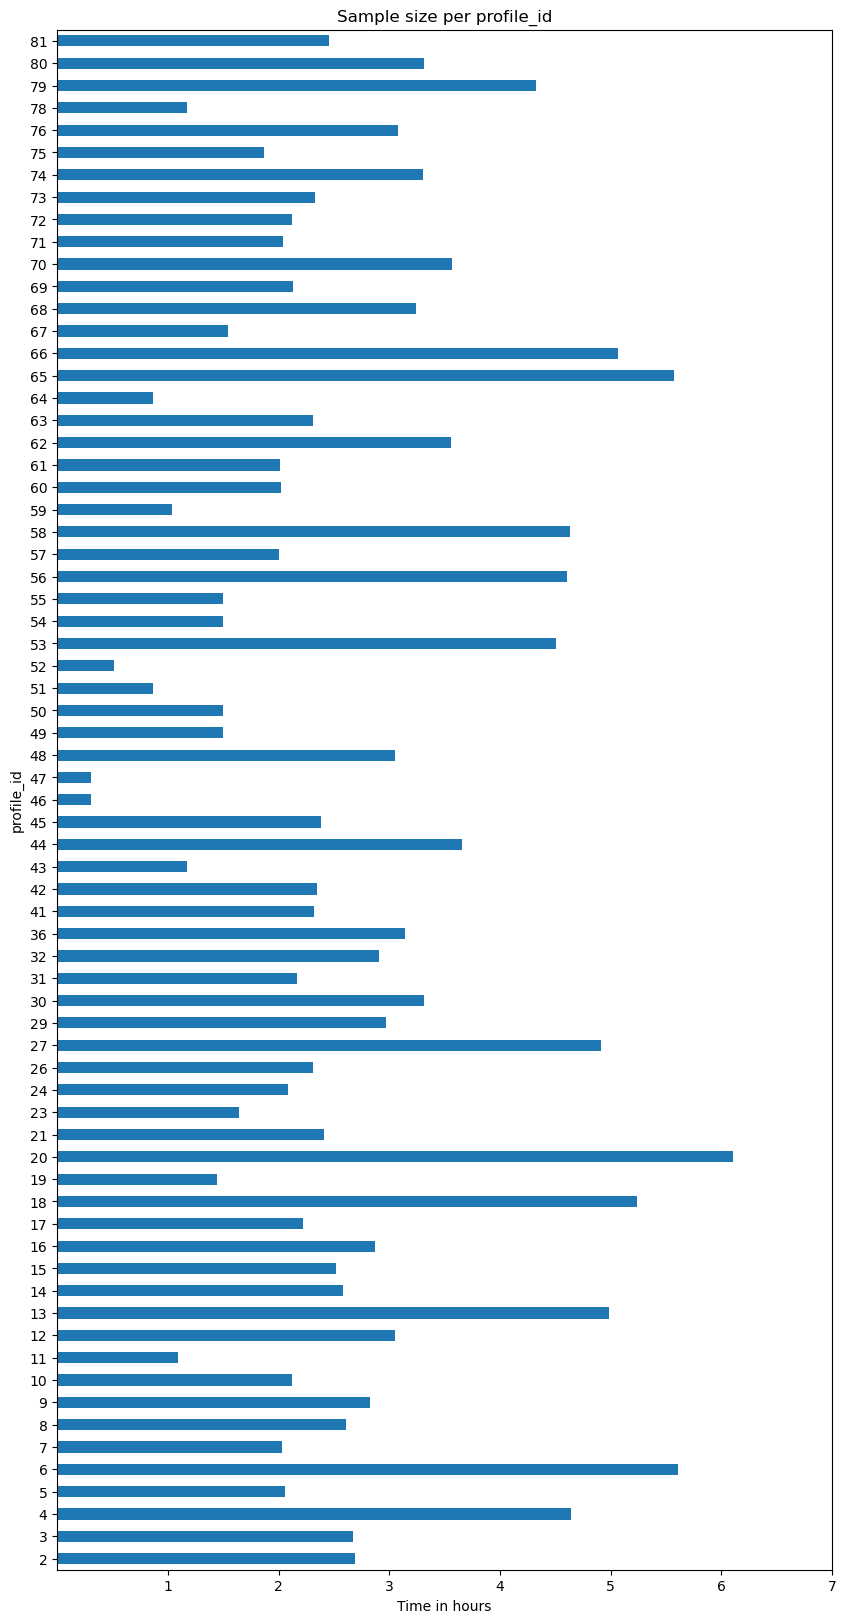

In [6]:
# Group by profile_id and count the number of samples
p_counts = df.groupby('profile_id')['ambient'].agg('count')  # Replace 'ambient' with any column

# Plot the sample sizes
ax = p_counts.plot.barh(figsize=(10, 20), title='Sample size per profile_id')

# Convert sample counts to time (if sampling rate is known)
sampling_rate = 2  # Replace with your dataset's sampling rate (in Hz)
_ = ax.set_xticks(sampling_rate * 3600 * np.arange(1, 8))  # Convert to hours
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

plt.show()

### *What Are These Sessions?*

1. Each profile_id corresponds to a unique measurement session where the motor was operated under specific conditions.

2. During each session, temperatures, voltages, currents, speed, torque was recorded at a sampling rate of 2 Hz (every 0.5 seconds).

***The two very short sessions (profile_id 46 and 47) might be Outliers so we wont be using it in our dataset***


### Time Series Plots

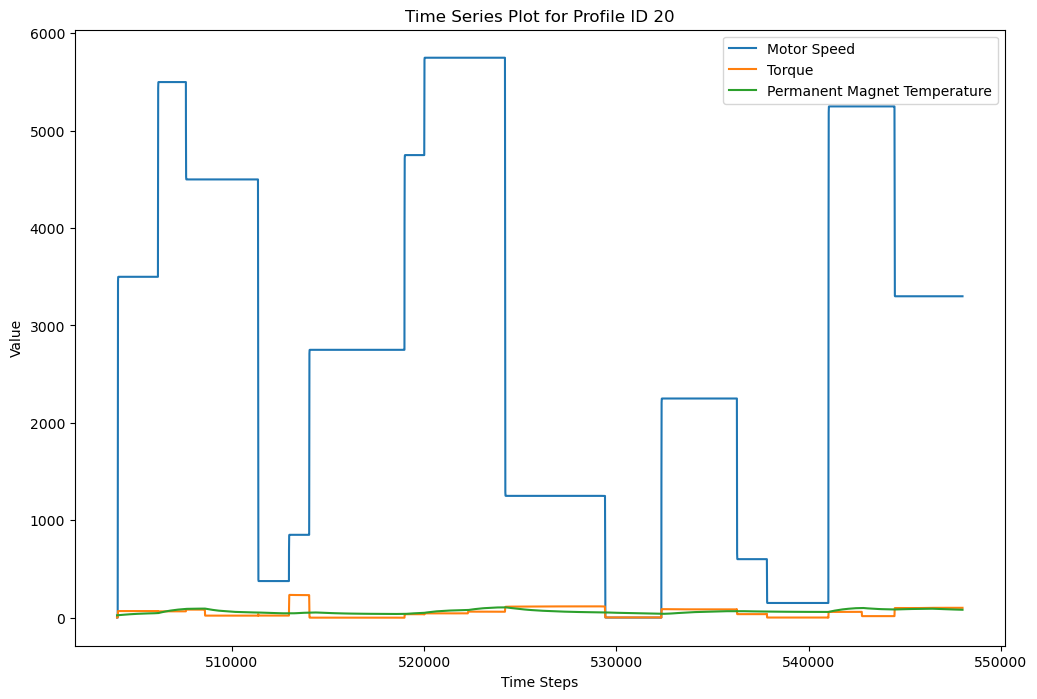

In [7]:
# Filter data for a specific profile_id
profile_data = df[df['profile_id'] == 20 ]

# Plot time series for selected features
plt.figure(figsize=(12, 8))
plt.plot(profile_data['motor_speed'], label='Motor Speed')
plt.plot(profile_data['torque'], label='Torque')
plt.plot(profile_data['pm'], label='Permanent Magnet Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Time Series Plot for Profile ID 20')
plt.legend()
plt.show()

# Duration Calculation for Time Steps

To calculate the duration corresponding to the new time steps ranging from **510,000** to **550,000** at a sampling rate of **2 Hz** (which means data is recorded every **0.5 seconds**), we can follow these steps:

## 1. Calculate the Number of Time Steps
\[
\text{Number of time steps} = 550,000 - 510,000 = 40,000 \text{ time steps}
\]

## 2. Convert Time Steps to Seconds
Since the dataset is sampled at **2 Hz** (every **0.5 seconds**), we can find the total duration in seconds as follows:
\[
\text{Total Duration (seconds)} = \text{Number of time steps} \times 0.5 \text{ seconds} = 40,000 \times 0.5 = 20,000 \text{ seconds}
\]

## 3. Convert Seconds to Hours
To convert seconds to hours:
\[
\text{Total Duration (hours)} = \frac{20,000 \text{ seconds}}{3600 \text{ seconds/hour}} \approx 5.56 \text{ hours}
\]

## Summary
The new time step range from **510,000** to **550,000** corresponds to exactly **20,000 seconds**, which is approximately **5.56 hours**.

# Session Length Analysis

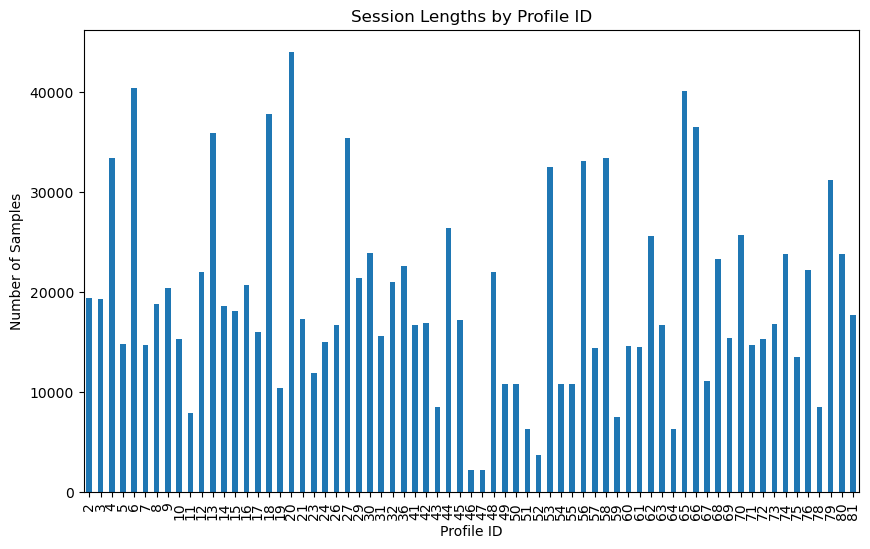

In [8]:
# Group by profile_id and count the number of samples
p_counts = df.groupby('profile_id').size()

# Plot session lengths
plt.figure(figsize=(10, 6))
p_counts.plot(kind='bar')
plt.xlabel('Profile ID')
plt.ylabel('Number of Samples')
plt.title('Session Lengths by Profile ID')
plt.show()

In [9]:
df3 = df.copy()

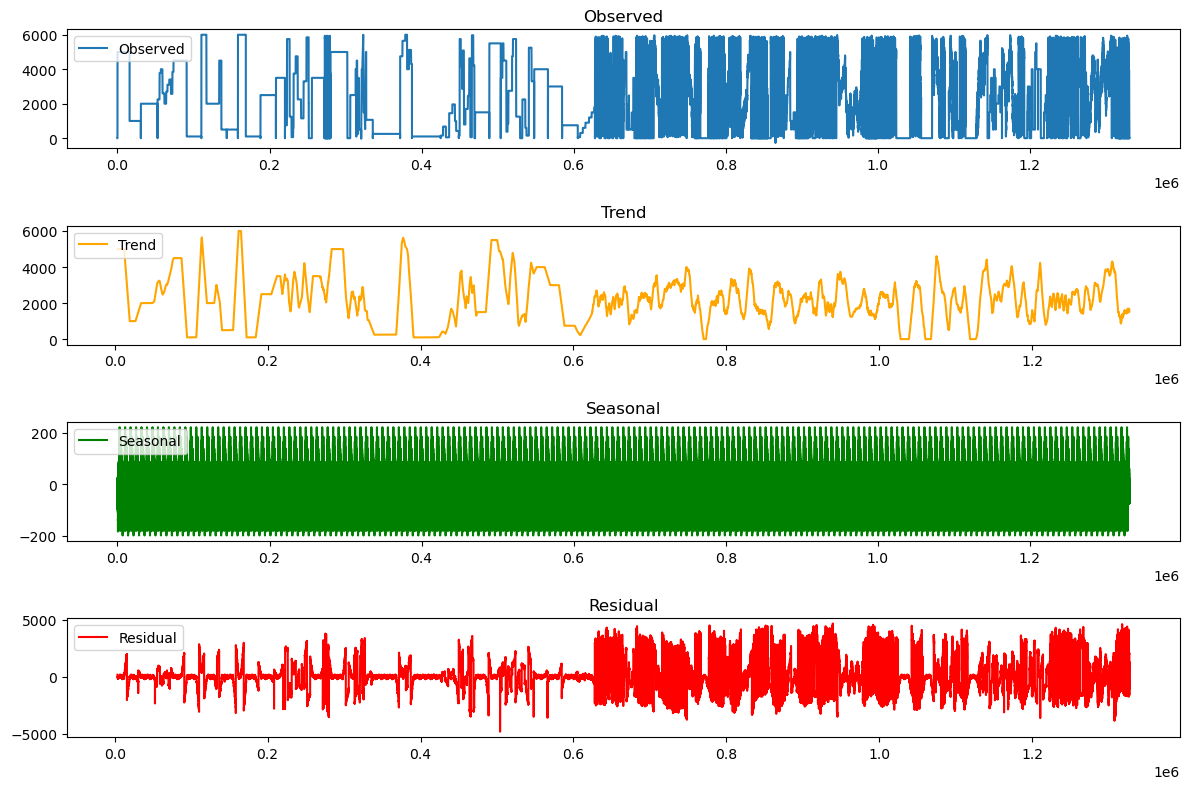

In [10]:
# Perform seasonal decomposition on 'motor_speed' in df3
decomposition = seasonal_decompose(df3['motor_speed'], model='additive', period=2*3600)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Observed
plt.subplot(4, 1, 1)
plt.plot(df3['motor_speed'], label='Observed')
plt.legend(loc='upper left')
plt.title('Observed')

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

# Residual
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

### Trend:

The trend is relatively stable, indicating that the variable (e.g., motor_speed) doesn't exhibit significant long-term changes over the observed period.

### Seasonality:

The seasonal component shows weak periodic patterns, suggesting that there is some repeating behavior in the data, but it is not very strong.

### Residual:

The residual component is small and random, indicating that the trend and seasonal components explain most of the variability in the data.### 

### Line Plots for Temperature Features

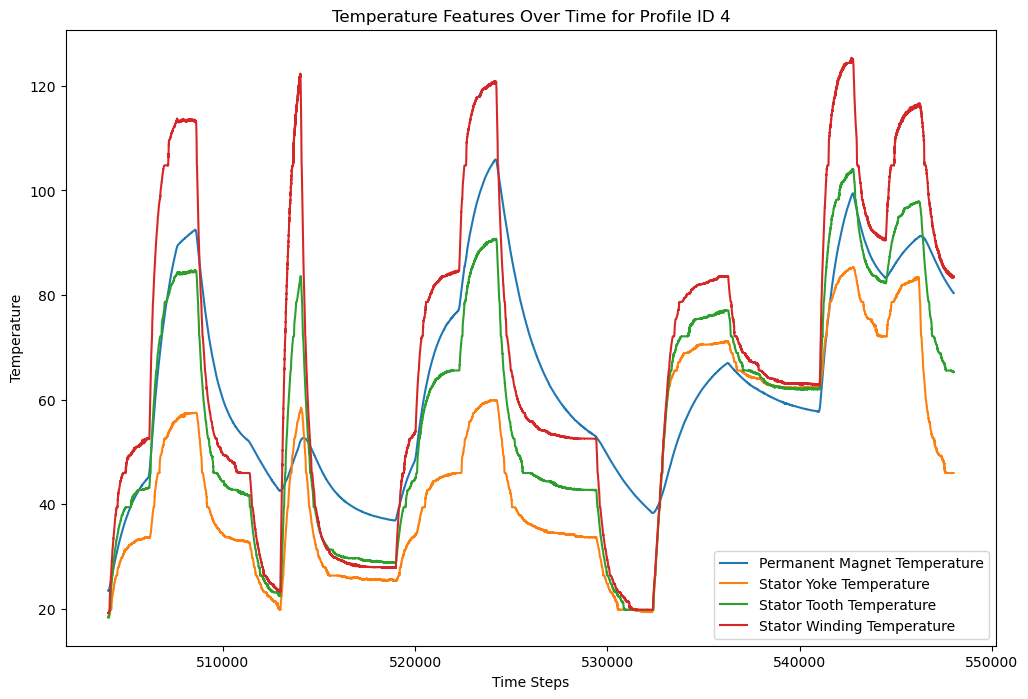

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(profile_data['pm'], label='Permanent Magnet Temperature')
plt.plot(profile_data['stator_yoke'], label='Stator Yoke Temperature')
plt.plot(profile_data['stator_tooth'], label='Stator Tooth Temperature')
plt.plot(profile_data['stator_winding'], label='Stator Winding Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Temperature Features Over Time for Profile ID 4')
plt.legend()

#### Drop the 'profile_id' column

In [12]:
df = df.drop(columns=['profile_id'])

#### Check Null Values

In [13]:
df.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
dtype: int64

#### Checking shape 

In [14]:
df.shape

(1330816, 12)

#### Check for duplicates

In [15]:

duplicates = df.duplicated()

# Display the duplicated rows
duplicated_rows = df[duplicates]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [ambient, coolant, u_d, u_q, motor_speed, torque, i_d, i_q, pm, stator_yoke, stator_tooth, stator_winding]
Index: []


In [16]:
# Count duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


#### Descriptive Statistics

In [17]:
df.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,2.456526e+01,3.622999e+01,-2.513381e+01,5.427900e+01,2.202081e+03,3.110603e+01,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,5.687858e+01,6.634275e+01
std,1.929522e+00,2.178615e+01,6.309197e+01,4.417323e+01,1.859663e+03,7.713575e+01,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,2.295223e+01,2.867206e+01
min,8.783478e+00,1.062375e+01,-1.315304e+02,-2.529093e+01,-2.755491e+02,-2.464667e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,1.813398e+01,1.858582e+01
25%,2.318480e+01,1.869814e+01,-7.869090e+01,1.206992e+01,3.171107e+02,-1.374265e-01,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,3.841601e+01,4.278796e+01
50%,2.479733e+01,2.690014e+01,-7.429755e+00,4.893818e+01,1.999977e+03,1.086035e+01,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,5.603635e+01,6.511013e+01
75%,2.621702e+01,4.985749e+01,1.470271e+00,9.003439e+01,3.760639e+03,9.159718e+01,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,7.558668e+01,8.814114e+01
max,3.071420e+01,1.015985e+02,1.314698e+02,1.330370e+02,6.000015e+03,2.610057e+02,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,1.119464e+02,1.413629e+02


#### Checking Min Max values for all features  **(Range for Deployment)**

In [75]:
# Calculate minimum and maximum values for each column
min_max_values = df.agg(['min', 'max'])

# Display the results
print("Minimum and Maximum values for each feature:")
min_max_values

Minimum and Maximum values for each feature:


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
min,8.783478,10.623751,-131.530411,-25.290930,-275.549144,-246.466663,-278.003632,-293.426793,20.856956,18.076689,18.133976,18.585815
max,30.714205,101.598512,131.469788,133.036994,6000.015137,261.005707,0.051897,301.707855,113.606628,101.147964,111.946423,141.362885


#### Distribution of Variables / Visualization

##### Histograms for numerical columns

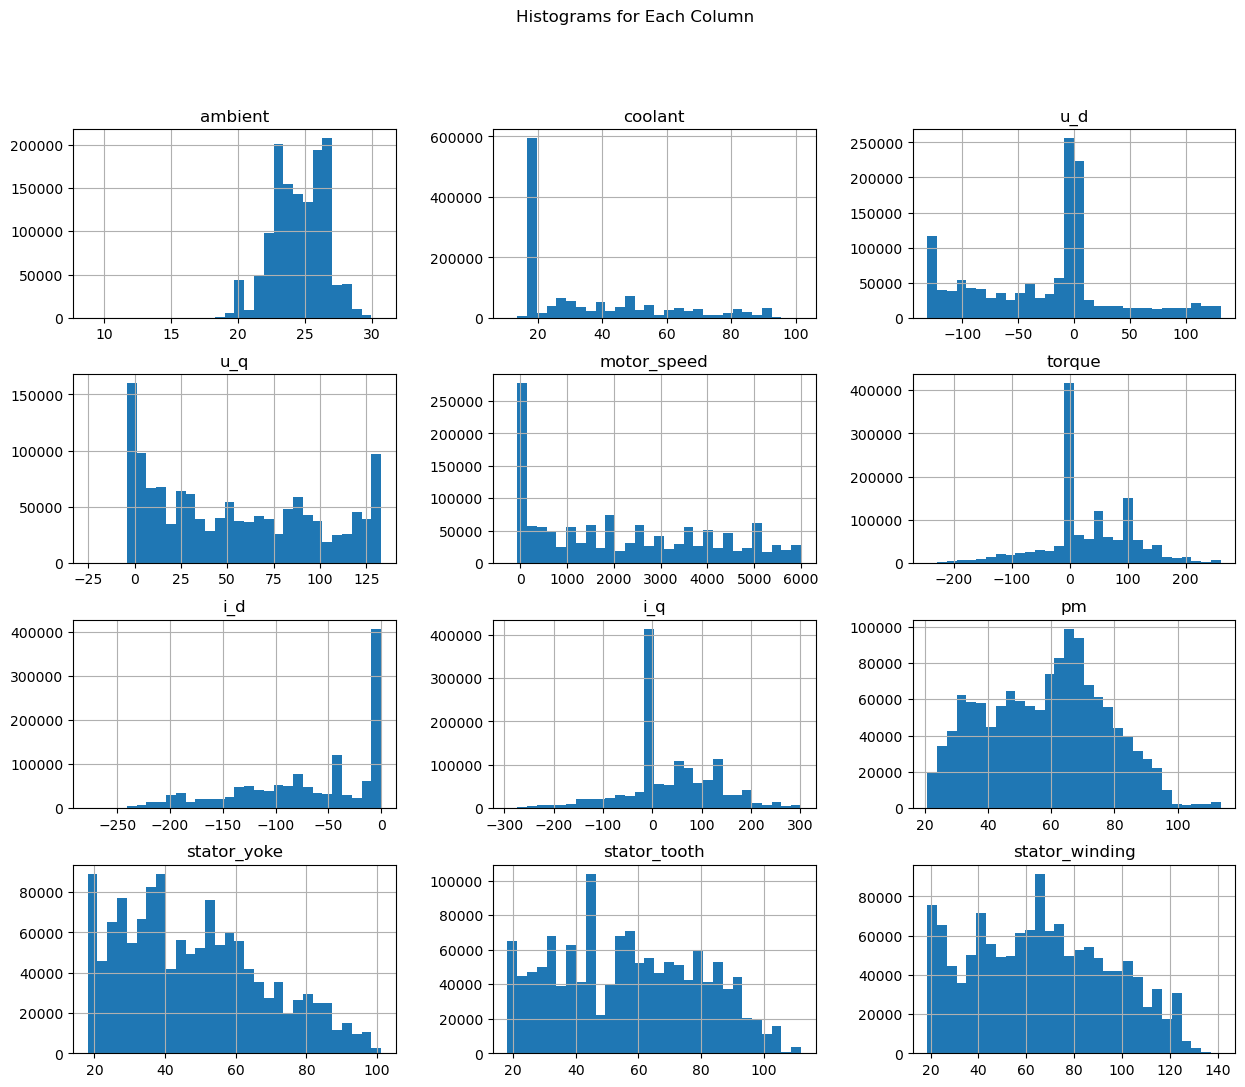

In [19]:
df.hist(bins=30, figsize=(15, 12))
plt.suptitle('Histograms for Each Column')
plt.show()

#### Check Skewness

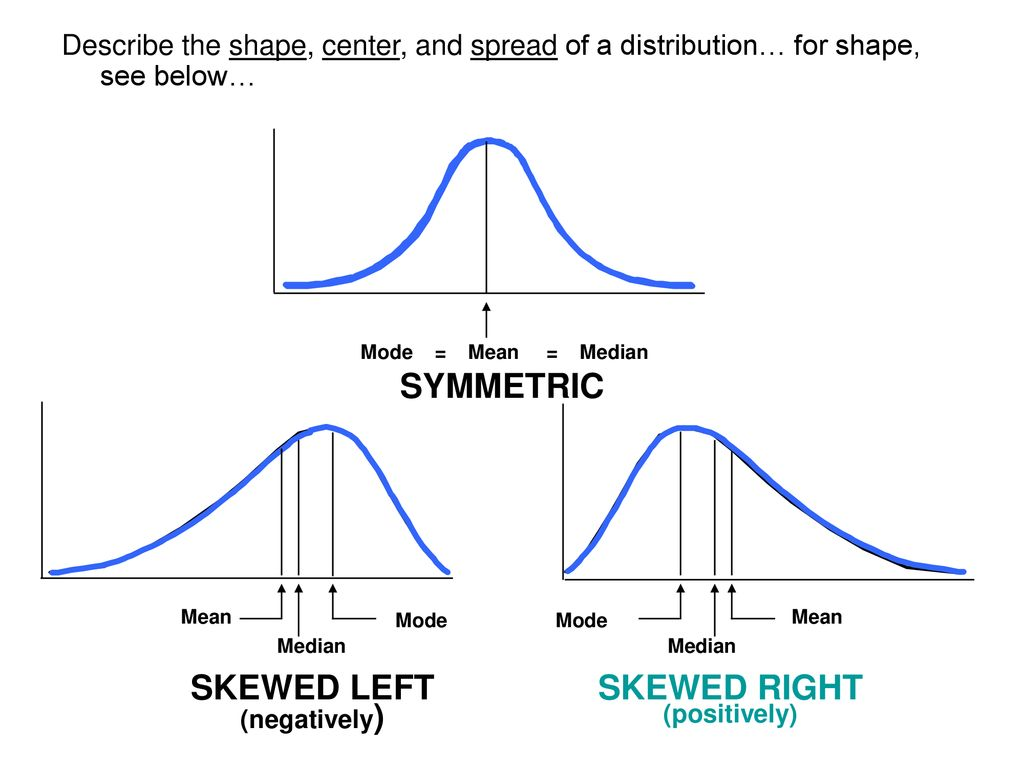

In [20]:
Image(filename=r"Skewed.jpg", width=700, height=200)

In [21]:
skewness = df.skew()
print("Skewness of each column:")
print(skewness)

Skewness of each column:
ambient          -0.349066
coolant           1.048115
u_d               0.145061
u_q               0.314933
motor_speed       0.386464
torque           -0.127141
i_d              -0.707305
i_q              -0.146505
pm                0.038312
stator_yoke       0.481009
stator_tooth      0.137610
stator_winding    0.167666
dtype: float64


### Negative Skewness (Left-Skewed):

##### ambient (-0.349066): Slightly left-skewed.

##### torque (-0.127141): Nearly symmetric (very slight left skew).

##### i_d (-0.707305): Moderately left-skewed.

##### i_q (-0.146505): Nearly symmetric (very slight left skew).

### Positive Skewness (Right-Skewed):

##### coolant (1.048115): Moderately right-skewed.

##### u_d (0.145061): Nearly symmetric (very slight right skew).

##### u_q (0.314933): Slightly right-skewed.

##### motor_speed (0.386464): Slightly right-skewed.

##### pm (0.038312): Nearly symmetric (very slight right skew).

##### stator_yoke (0.481009): Slightly right-skewed.

##### stator_tooth (0.137610): Nearly symmetric (very slight right skew).

##### stator_winding (0.167666): Nearly symmetric (very slight right skew).

### Summary:

##### Left-Skewed Variables: Ambient, torque, i_d, and i_q.

##### Right-Skewed Variables: Coolant, u_d, u_q, motor_speed, pm, stator_yoke, stator_tooth, and stator_winding.

#### ***Most variables are either nearly symmetric or slightly skewed, with coolant being the most right-skewed and i_d being the most left-skewed.***


### When to Apply Transformations?

##### Left-Skewed Data (Negative Skewness):

Apply transformations like reflection + log or reflection + square root.

##### Right-Skewed Data (Positive Skewness):

Apply transformations like log, square root, or Box-Cox.

##### Nearly Symmetric Data (Skewness Close to 0):

No transformation is needed, but monitor the data during analysis.





### I have not applied Transformation because The Skewness is Mild & Some machine learning models (e.g., decision trees, random forests, gradient boosting) are less sensitive to skewed data and can handle it without transformations.

 # Check For Outliers

#### What to do with outliers?

We have three basic options for outliers:

#### 1. Ignore them — just include them in the data and all analyses

#### 2. Remove them completely from the DataFrame (TRIMMING)

#### 3. Replace them with non-outlier values (CAPPING)

#### When to Use Z-Score for Outliers

Use Z-scores when your data is approximately normally distributed.

For non-normal distributions, consider other methods like the IQR (Interquartile Range) method.

In [22]:
# Calculate Z-scores
from scipy.stats import zscore
z_scores = df.apply(zscore)

# Identify outliers (absolute Z-score > 3)
outliers = (z_scores.abs() > 3)

# Count outliers in each column
outlier_counts = outliers.sum()

print("Outliers in each column:")
print(outlier_counts)

# Around 11,000 Outliers detected using Z -score

Outliers in each column:
ambient            483
coolant              1
u_d                  0
u_q                  0
motor_speed          0
torque            5835
i_d                500
i_q               6174
pm                   0
stator_yoke          0
stator_tooth         0
stator_winding       0
dtype: int64


### **Types of Outliers**

| **Type of Outlier**       | **Description**                                                                 | **Example**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Point Outliers**         | Individual data points that are significantly different from the rest of the data. | A single unusually high or low value in a dataset (e.g., a temperature reading of 1000°C). |
| **Contextual Outliers**    | Data points that are outliers in a specific context but not necessarily in the entire dataset. | A temperature of 30°C might be normal in summer but an outlier in winter.   |
| **Collective Outliers**    | A group of data points that are collectively unusual, even if individually they are not outliers. | A sudden spike in website traffic due to a viral event.                     |
| **Global Outliers**        | Data points that are outliers relative to the entire dataset.                   | A person who is 8 feet tall in a dataset of human heights.                  |
| **Local Outliers**         | Data points that are outliers within a specific subset of the data.             | A student scoring 100% in a class where most students score below 50%.      |

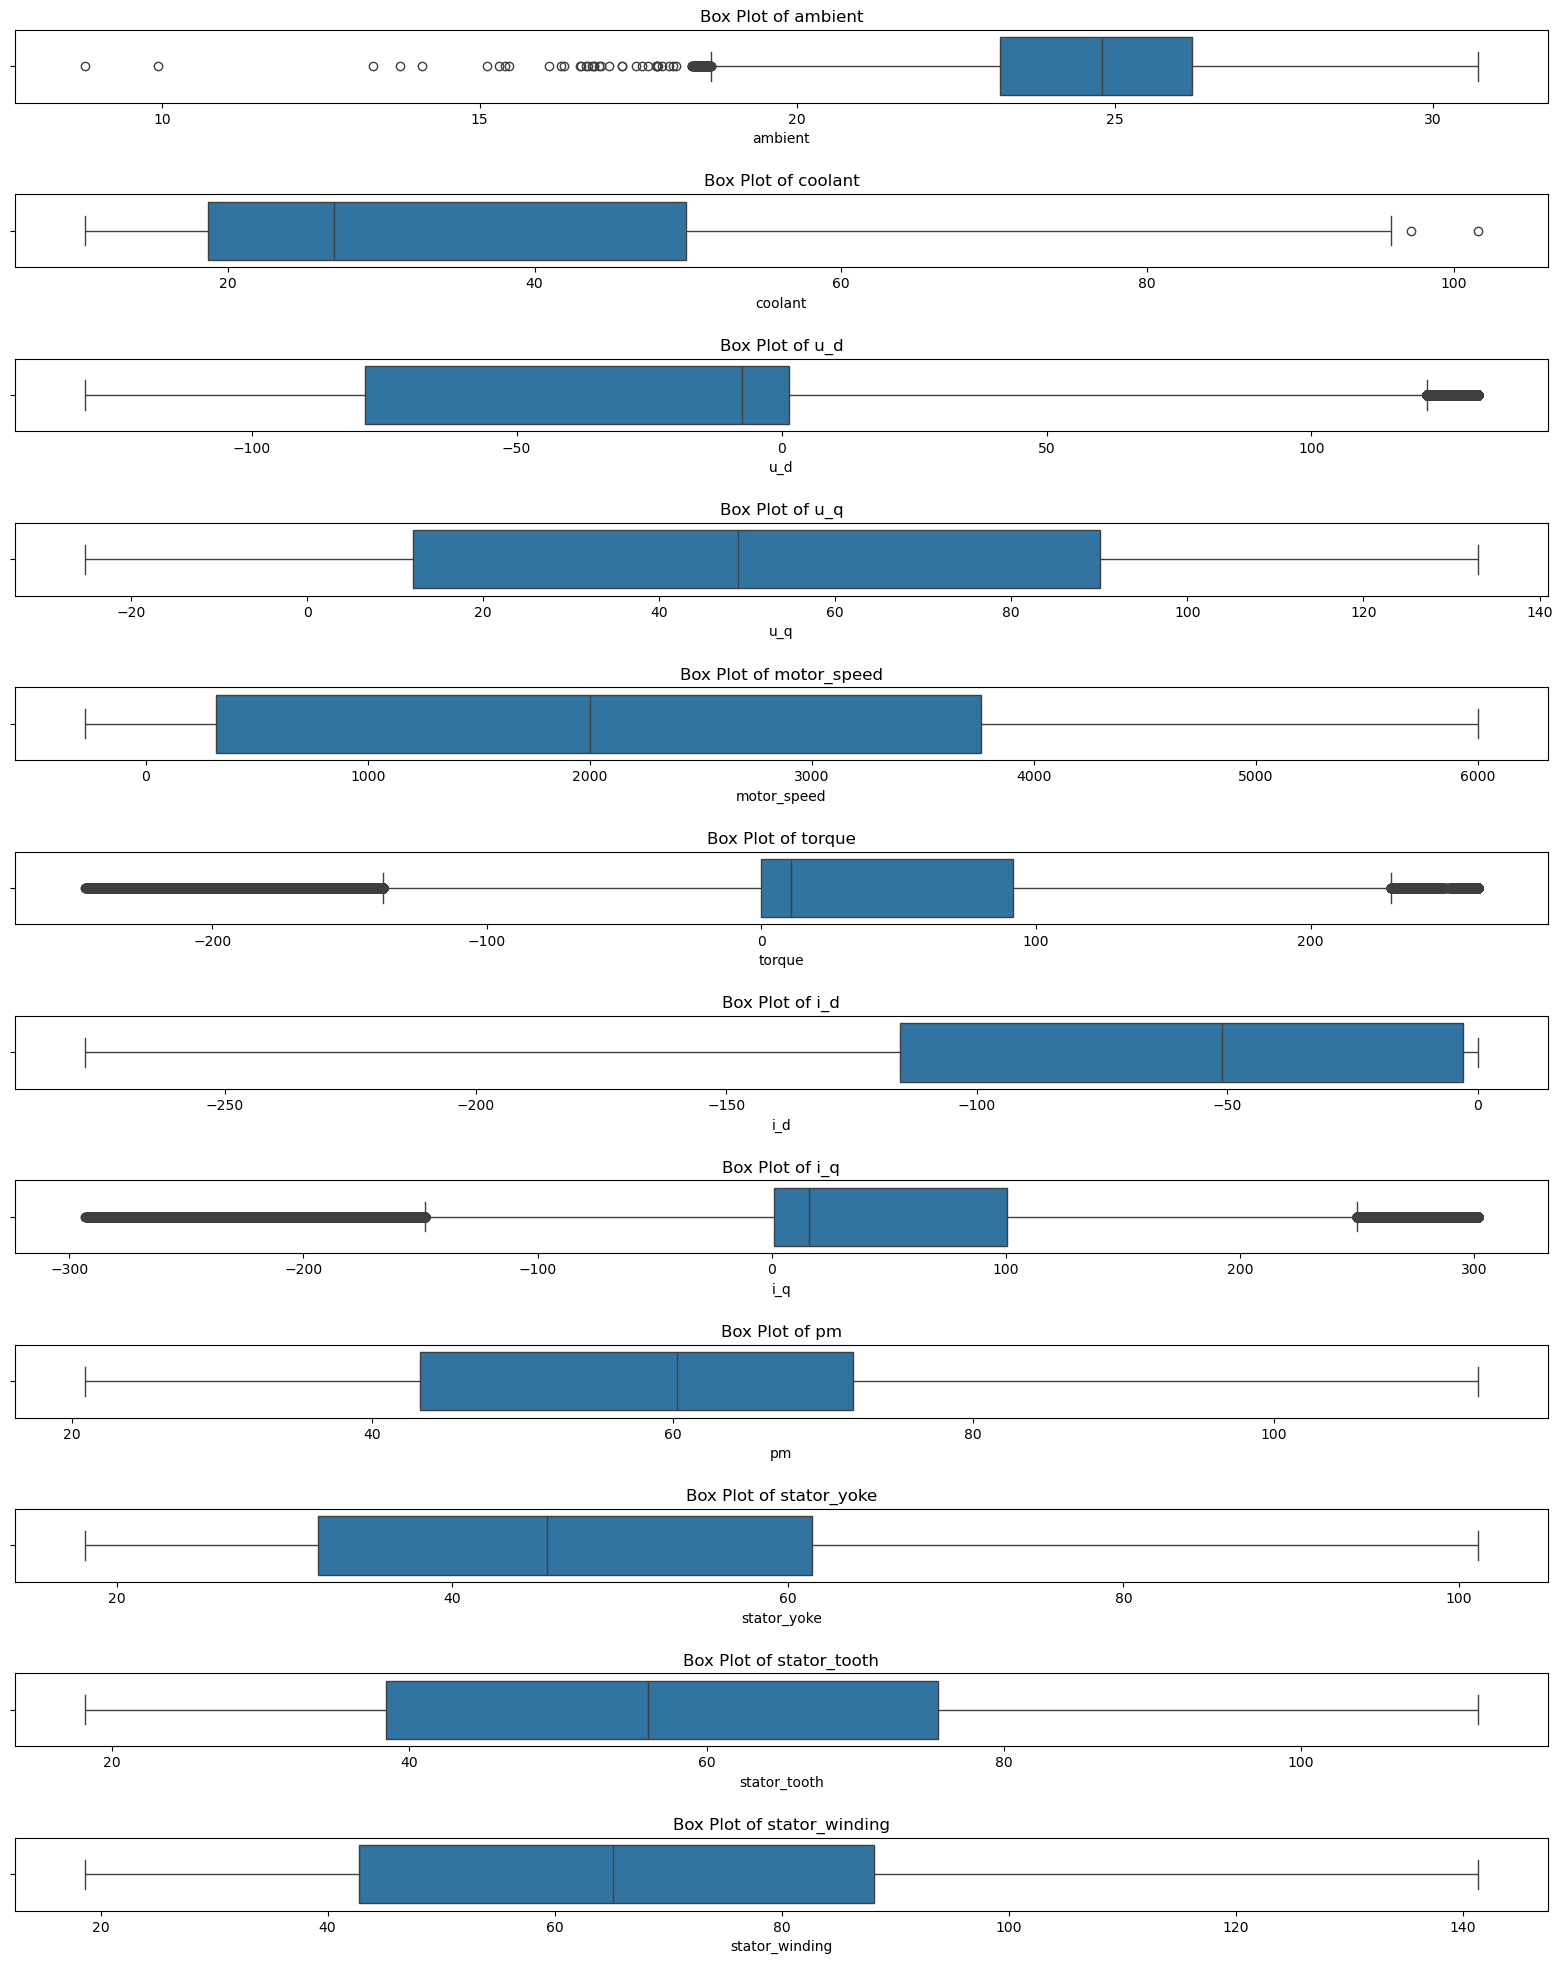

In [23]:
# Create subplots
fig, axes = plt.subplots(12, 1, figsize=(16, 20), sharex=False, sharey=False)

# Plot box plots for each column
sns.boxplot(x='ambient', data=df, ax=axes[0])
sns.boxplot(x='coolant', data=df, ax=axes[1])
sns.boxplot(x='u_d', data=df, ax=axes[2])
sns.boxplot(x='u_q', data=df, ax=axes[3])
sns.boxplot(x='motor_speed', data=df, ax=axes[4])
sns.boxplot(x='torque', data=df, ax=axes[5])
sns.boxplot(x='i_d', data=df, ax=axes[6])
sns.boxplot(x='i_q', data=df, ax=axes[7])
sns.boxplot(x='pm', data=df, ax=axes[8])
sns.boxplot(x='stator_yoke', data=df, ax=axes[9])
sns.boxplot(x='stator_tooth', data=df, ax=axes[10])
sns.boxplot(x='stator_winding', data=df, ax=axes[11])

# Add titles to subplots
axes[0].set_title('Box Plot of ambient', fontsize=12)
axes[1].set_title('Box Plot of coolant', fontsize=12)
axes[2].set_title('Box Plot of u_d', fontsize=12)
axes[3].set_title('Box Plot of u_q', fontsize=12)
axes[4].set_title('Box Plot of motor_speed', fontsize=12)
axes[5].set_title('Box Plot of torque', fontsize=12)
axes[6].set_title('Box Plot of i_d', fontsize=12)
axes[7].set_title('Box Plot of i_q', fontsize=12)
axes[8].set_title('Box Plot of pm', fontsize=12)
axes[9].set_title('Box Plot of stator_yoke', fontsize=12)
axes[10].set_title('Box Plot of stator_tooth', fontsize=12)
axes[11].set_title('Box Plot of stator_winding', fontsize=12)


# Adjust layout
plt.tight_layout(pad=2.0)
plt.show()

In [24]:
outlier = "Outlier.svg"
SVG(filename=outlier)

#### Why we will be using IQR and not Z-score?

| **Aspect**      | **Z-Score (Normal Data)**                                                                 | **IQR (Non-Normal Data)**                                                                 |
|------------------|------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Assumption**   | Assumes data is normally distributed.                                                    | No assumption about distribution. Non-parametric and works well for skewed or non-normal data. |
| **How it Works** | Measures how many standard deviations a data point is from the mean. Outliers are typically defined as Z-score > 3 or < -3. | IQR is the range between Q1 (25th percentile) and Q3 (75th percentile). Outliers are defined as data points below Q1 - 1.5×IQR or above Q3 + 1.5×IQR. |
| **Why it Works** | In a normal distribution, ~99.7% of data lies within ±3 standard deviations from the mean. | Based on percentiles, which are robust to skewness and extreme values. Focuses on the middle 50% of the data. |
| **Limitations**  | Misidentifies outliers if data is not normally distributed, as mean and standard deviation are influenced by skewness or extreme values. | For normally distributed data, IQR might be less precise than Z-score as it doesn't leverage the properties of the normal distribution. |

#### Removing Outliers using IQR with Trimming technique

In [25]:
# Create a copy of the DataFrame to avoid modifying the original
df1 = df.copy()

#### Trim Outliers from the ambient Column

In [26]:
# Calculate Q1, Q3, and IQR

Q1_amb = df1['ambient'].quantile(0.25)
Q3_amb = df1['ambient'].quantile(0.75)

IQR_amb = Q3_amb - Q1_amb
IQR_amb

3.032214599789846

In [27]:
# Define lower and upper bounds for the 'ambient' column
lower_bound_amb = Q1_amb - 1.5 * IQR_amb
upper_bound_amb = Q3_amb + 1.5 * IQR_amb

lower_bound_amb,upper_bound_amb

(18.636482539859912, 30.765340939019296)

In [28]:
# Trim outliers from the 'ambient' column
df1_trimmed = df1[(df1['ambient'] >= lower_bound_amb) & (df1['ambient'] <= upper_bound_amb)]
df1_trimmed

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,1.871008e-01,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,2.454175e-01,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,1.766153e-01,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,2.383027e-01,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,2.081967e-01,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525
...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,23.989078,30.721298,0.791801,-2.152128,0.000380,-8.116730e-60,-2.000169,1.097528,62.147780,38.653720,41.934347,45.274497
1330812,23.970700,30.721306,0.778900,-2.258684,0.002985,-5.815891e-60,-2.000499,1.097569,62.142646,38.656328,41.868923,45.239017
1330813,23.977234,30.721312,0.804914,-2.130312,0.002301,-4.167268e-60,-1.999268,1.098765,62.138387,38.650923,41.804819,45.211576
1330814,24.001421,30.721316,0.763091,-2.268498,0.005662,-2.985978e-60,-2.000999,1.095696,62.133422,38.655686,41.762220,45.193508


In [29]:
df1 = df1_trimmed

In [30]:
df.shape # Original Data

(1330816, 12)

In [31]:
df1.shape # Copy data After Removing Outliers

(1330557, 12)

#### Trim Outliers from the coolant Column

In [32]:
# Calculate Q1, Q3, and IQR for the 'coolant' column
Q1_coolant = df1['coolant'].quantile(0.25)
Q3_coolant = df1['coolant'].quantile(0.75)

IQR_coolant = Q3_coolant - Q1_coolant
IQR_coolant

31.159545427800403

In [33]:
# Define lower and upper bounds for the 'coolant' column
lower_bound_coolant = Q1_coolant - 1.5 * IQR_coolant
upper_bound_coolant = Q3_coolant + 1.5 * IQR_coolant

lower_bound_coolant, upper_bound_coolant

(-28.04107786154924, 96.59710384965237)

In [34]:
# Trim outliers from the 'coolant' column
df1_trimmed_coolant = df1[(df1['coolant'] >= lower_bound_coolant) & (df1['coolant'] <= upper_bound_coolant)]
df1_trimmed_coolant

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,1.871008e-01,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,2.454175e-01,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,1.766153e-01,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,2.383027e-01,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,2.081967e-01,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525
...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,23.989078,30.721298,0.791801,-2.152128,0.000380,-8.116730e-60,-2.000169,1.097528,62.147780,38.653720,41.934347,45.274497
1330812,23.970700,30.721306,0.778900,-2.258684,0.002985,-5.815891e-60,-2.000499,1.097569,62.142646,38.656328,41.868923,45.239017
1330813,23.977234,30.721312,0.804914,-2.130312,0.002301,-4.167268e-60,-1.999268,1.098765,62.138387,38.650923,41.804819,45.211576
1330814,24.001421,30.721316,0.763091,-2.268498,0.005662,-2.985978e-60,-2.000999,1.095696,62.133422,38.655686,41.762220,45.193508


In [35]:
df1 = df1_trimmed_coolant

In [36]:
df.shape 

(1330816, 12)

In [37]:
df1.shape # Copy data After Removing 2 Outliers

(1330555, 12)

#### Trim Outliers from the u_d Column

In [38]:
# Calculate Q1, Q3, and IQR for the 'u_d' column
Q1_ud = df1['u_d'].quantile(0.25)  # 25th percentile (Q1)
Q3_ud = df1['u_d'].quantile(0.75)  # 75th percentile (Q3)

IQR_ud = Q3_ud - Q1_ud  # Interquartile Range
IQR_ud

80.11416402719132

In [39]:
# Define lower and upper bounds for the 'u_d' column
lower_bound_ud = Q1_ud - 1.5 * IQR_ud
upper_bound_ud = Q3_ud + 1.5 * IQR_ud

lower_bound_ud,upper_bound_ud

(-198.81508835310024, 121.64156775566506)

In [40]:
# Trim outliers from the 'u_d' column
df1_trimmed_ud = df1[(df1['u_d'] >= lower_bound_ud) & (df1['u_d'] <= upper_bound_ud)]

df1_trimmed_ud

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,1.871008e-01,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,2.454175e-01,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,1.766153e-01,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,2.383027e-01,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,2.081967e-01,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525
...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,23.989078,30.721298,0.791801,-2.152128,0.000380,-8.116730e-60,-2.000169,1.097528,62.147780,38.653720,41.934347,45.274497
1330812,23.970700,30.721306,0.778900,-2.258684,0.002985,-5.815891e-60,-2.000499,1.097569,62.142646,38.656328,41.868923,45.239017
1330813,23.977234,30.721312,0.804914,-2.130312,0.002301,-4.167268e-60,-1.999268,1.098765,62.138387,38.650923,41.804819,45.211576
1330814,24.001421,30.721316,0.763091,-2.268498,0.005662,-2.985978e-60,-2.000999,1.095696,62.133422,38.655686,41.762220,45.193508


In [41]:
df1 = df1_trimmed_ud

In [42]:
df.shape # Original Data

(1330816, 12)

In [43]:
df1.shape # Copy data After Removing Outliers

(1311551, 12)

#### Trim Outliers from the torque Column

In [44]:
# Calculate Q1, Q3, and IQR for the 'torque' column
Q1_torque = df1['torque'].quantile(0.25)  # 25th percentile (Q1)
Q3_torque = df1['torque'].quantile(0.75)  # 75th percentile (Q3)

IQR_torque = Q3_torque - Q1_torque  # Interquartile Range
IQR_torque

93.2275320533663

In [45]:
# Define lower and upper bounds for the 'torque' column

lower_bound_torque = Q1_torque - 1.5 * IQR_torque
upper_bound_torque = Q3_torque + 1.5 * IQR_torque

lower_bound_torque, upper_bound_torque

(-139.8747230777517, 233.03540513571352)

In [46]:
# Trim outliers from the 'torque' column
df1_trimmed_torque = df1[(df1['torque'] >= lower_bound_torque) & (df1['torque'] <= upper_bound_torque)]

df1_trimmed_torque

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,1.871008e-01,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,2.454175e-01,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,1.766153e-01,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,2.383027e-01,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,2.081967e-01,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525
...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,23.989078,30.721298,0.791801,-2.152128,0.000380,-8.116730e-60,-2.000169,1.097528,62.147780,38.653720,41.934347,45.274497
1330812,23.970700,30.721306,0.778900,-2.258684,0.002985,-5.815891e-60,-2.000499,1.097569,62.142646,38.656328,41.868923,45.239017
1330813,23.977234,30.721312,0.804914,-2.130312,0.002301,-4.167268e-60,-1.999268,1.098765,62.138387,38.650923,41.804819,45.211576
1330814,24.001421,30.721316,0.763091,-2.268498,0.005662,-2.985978e-60,-2.000999,1.095696,62.133422,38.655686,41.762220,45.193508


In [47]:
df1=df1_trimmed_torque

In [48]:
df.shape # Original Data

(1330816, 12)

In [49]:
df1.shape # Copy data After Removing Outliers

(1277946, 12)

#### Trim Outliers from the i_q Column

In [50]:
# Calculate Q1, Q3, and IQR for the 'i_q' column
Q1_iq = df1['i_q'].quantile(0.25)  # 25th percentile (Q1)
Q3_iq = df1['i_q'].quantile(0.75)  # 75th percentile (Q3)
IQR_iq = Q3_iq - Q1_iq  # Interquartile Range

# Define lower and upper bounds for the 'i_q' column
lower_bound_iq = Q1_iq - 1.5 * IQR_iq
upper_bound_iq = Q3_iq + 1.5 * IQR_iq

IQR_iq, lower_bound_iq, upper_bound_iq

(101.80879977963636, -151.6167908614444, 255.618408257101)

In [51]:
# Trim outliers from the 'i_q' column
df1_trimmed_iq = df1[(df1['i_q'] >= lower_bound_iq) & (df1['i_q'] <= upper_bound_iq)]

df1_trimmed_iq


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,1.871008e-01,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,2.454175e-01,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,1.766153e-01,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,2.383027e-01,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,2.081967e-01,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525
...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,23.989078,30.721298,0.791801,-2.152128,0.000380,-8.116730e-60,-2.000169,1.097528,62.147780,38.653720,41.934347,45.274497
1330812,23.970700,30.721306,0.778900,-2.258684,0.002985,-5.815891e-60,-2.000499,1.097569,62.142646,38.656328,41.868923,45.239017
1330813,23.977234,30.721312,0.804914,-2.130312,0.002301,-4.167268e-60,-1.999268,1.098765,62.138387,38.650923,41.804819,45.211576
1330814,24.001421,30.721316,0.763091,-2.268498,0.005662,-2.985978e-60,-2.000999,1.095696,62.133422,38.655686,41.762220,45.193508


In [52]:
df1 = df1_trimmed_iq

In [53]:
df.shape  # Original Data

(1330816, 12)

In [54]:
df1.shape # Data after Removing Outliers

(1263195, 12)

### Conclusion
Well As we can see When using the trimming method to remove outliers, the size of the dataset is somewhat significantly reduced. Let’s break down the impact:

#### Original Dataset:
-Size: 1,330,816 rows × 12 columns.

-Outliers: 67,621 rows (5% of the dataset).

#### After Trimming:
-Size: 1,263,195 rows × 12 columns.

-Loss:  67,621 rows (5% of the dataset).

##### From Above Observation We can see that their is loss Of Data. We've observed that trimming (removing outliers) resulted in a loss of approximately 67,621 records (5% of the dataset). This is a not that significant reduction.

### *Trimming may not always be the best approach, especially when the loss of data is significant. Instead, alternative methods like Capping (winsorization) should be considered. Capping retains the dataset size by replacing outliers with upper or lower bounds, reducing their impact without losing valuable data. This approach ensures that the dataset remains representative and suitable for analysis and modeling while mitigating the influence of extreme values.*

#### Removing Outliers using IQR with Capping technique

In [55]:
# Create a copy of the dataset
df2 = df.copy()


#### Capping Outliers from the Ambient Column

In [56]:
# Calculate Q1, Q3, and IQR for the 'ambient' column

Q1_ambient_cap = df2['ambient'].quantile(0.25)  # 25th percentile
Q3_ambient_cap = df2['ambient'].quantile(0.75)  # 75th percentile

IQR_ambient_cap = Q3_ambient_cap - Q1_ambient_cap  # Interquartile Range

IQR_ambient_cap

3.032214599789846

In [57]:
# Define lower and upper bounds for 'ambient'

lower_bound_ambient_cap = Q1_ambient_cap - 1.5 * IQR_ambient_cap
upper_bound_ambient_cap = Q3_ambient_cap + 1.5 * IQR_ambient_cap

lower_bound_ambient_cap, upper_bound_ambient_cap

(18.636482539859912, 30.765340939019296)

In [58]:
# Cap outliers in the 'ambient' column (replace existing column)
df2['ambient'] = df2['ambient'].clip(lower=lower_bound_ambient_cap, upper=upper_bound_ambient_cap)


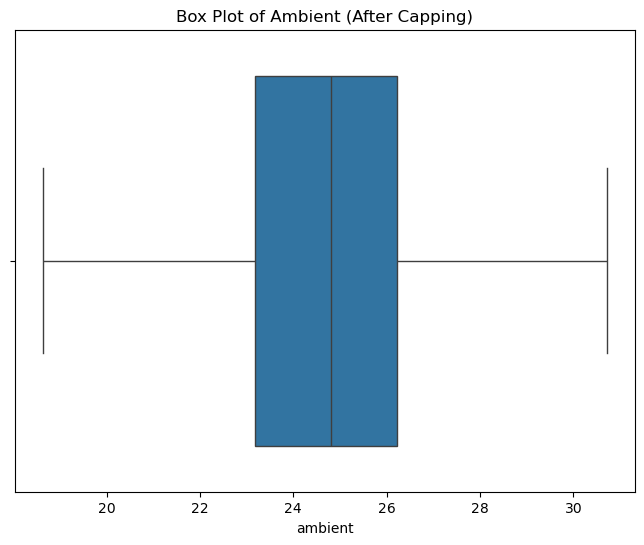

In [59]:
# Create a box plot for the capped 'ambient' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df2['ambient'])
plt.title('Box Plot of Ambient (After Capping)')
plt.show()

#### Capping Outliers from the Coolant Column

In [60]:
# Calculate Q1, Q3, and IQR for the 'coolant' column
Q1_coolant_cap = df2['coolant'].quantile(0.25)  # 25th percentile
Q3_coolant_cap = df2['coolant'].quantile(0.75)  # 75th percentile

IQR_coolant_cap = Q3_coolant_cap - Q1_coolant_cap  # Interquartile Range

IQR_coolant_cap

31.159351547539327

In [61]:
# Define lower and upper bounds for 'coolant'
lower_bound_coolant_cap = Q1_coolant_cap - 1.5 * IQR_coolant_cap
upper_bound_coolant_cap = Q3_coolant_cap + 1.5 * IQR_coolant_cap

lower_bound_coolant_cap, upper_bound_coolant_cap

(-28.04089194533243, 96.59651424482487)

In [62]:
# Cap outliers in the 'coolant' column (replace existing column)
df2['coolant'] = df2['coolant'].clip(lower=lower_bound_coolant_cap, upper=upper_bound_coolant_cap)

#### Capping Outliers from the u_d Column

In [63]:
# Calculate Q1, Q3, and IQR for the 'u_d' column
Q1_ud_cap = df2['u_d'].quantile(0.25)  # 25th percentile
Q3_ud_cap = df2['u_d'].quantile(0.75)  # 75th percentile

IQR_ud_cap = Q3_ud_cap - Q1_ud_cap  # Interquartile Range
IQR_ud_cap

80.16117460886946

In [64]:
# Define lower and upper bounds for 'u_d'
lower_bound_ud_cap = Q1_ud_cap - 1.5 * IQR_ud_cap
upper_bound_ud_cap = Q3_ud_cap + 1.5 * IQR_ud_cap

lower_bound_ud_cap,upper_bound_ud_cap

(-198.93266597788312, 121.71203245759473)

In [65]:
# Cap outliers in the 'u_d' column (replace existing column)

df2['u_d'] = df2['u_d'].clip(lower=lower_bound_ud_cap, upper=upper_bound_ud_cap)

#### Capping Outliers from the torque Column

In [66]:
# Calculate Q1, Q3, and IQR for the 'torque' column
Q1_torque_cap = df2['torque'].quantile(0.25)  # 25th percentile
Q3_torque_cap = df2['torque'].quantile(0.75)  # 75th percentile

IQR_torque_cap = Q3_torque_cap - Q1_torque_cap  # Interquartile Range
IQR_torque_cap

91.73460229543925

In [67]:
# Define lower and upper bounds for 'torque'

lower_bound_torque_cap = Q1_torque_cap - 1.5 * IQR_torque_cap
upper_bound_torque_cap = Q3_torque_cap + 1.5 * IQR_torque_cap
lower_bound_torque_cap,upper_bound_torque_cap

(-137.73932997223855, 229.19907920951846)

In [68]:
# Cap outliers in the 'torque' column (replace existing column)

df2['torque'] = df2['torque'].clip(lower=lower_bound_torque_cap, upper=upper_bound_torque_cap)

#### Capping Outliers from the i_q Column

In [69]:
# Calculate Q1, Q3, and IQR for the 'i_q' column

Q1_iq_cap = df2['i_q'].quantile(0.25)  # 25th percentile
Q3_iq_cap = df2['i_q'].quantile(0.75)  # 75th percentile

IQR_iq_cap = Q3_iq_cap - Q1_iq_cap  # Interquartile Range
IQR_iq_cap

99.51628666507519

In [70]:
# Define lower and upper bounds for 'i_q'
lower_bound_iq_cap = Q1_iq_cap - 1.5 * IQR_iq_cap
upper_bound_iq_cap = Q3_iq_cap + 1.5 * IQR_iq_cap

lower_bound_iq_cap,upper_bound_iq_cap

(-148.17856715058244, 249.88657950971827)

In [71]:
# Cap outliers in the 'i_q' column (replace existing column)
df2['i_q'] = df2['i_q'].clip(lower=lower_bound_iq_cap, upper=upper_bound_iq_cap)

#### Lets visualize the Capped columns using boxplots

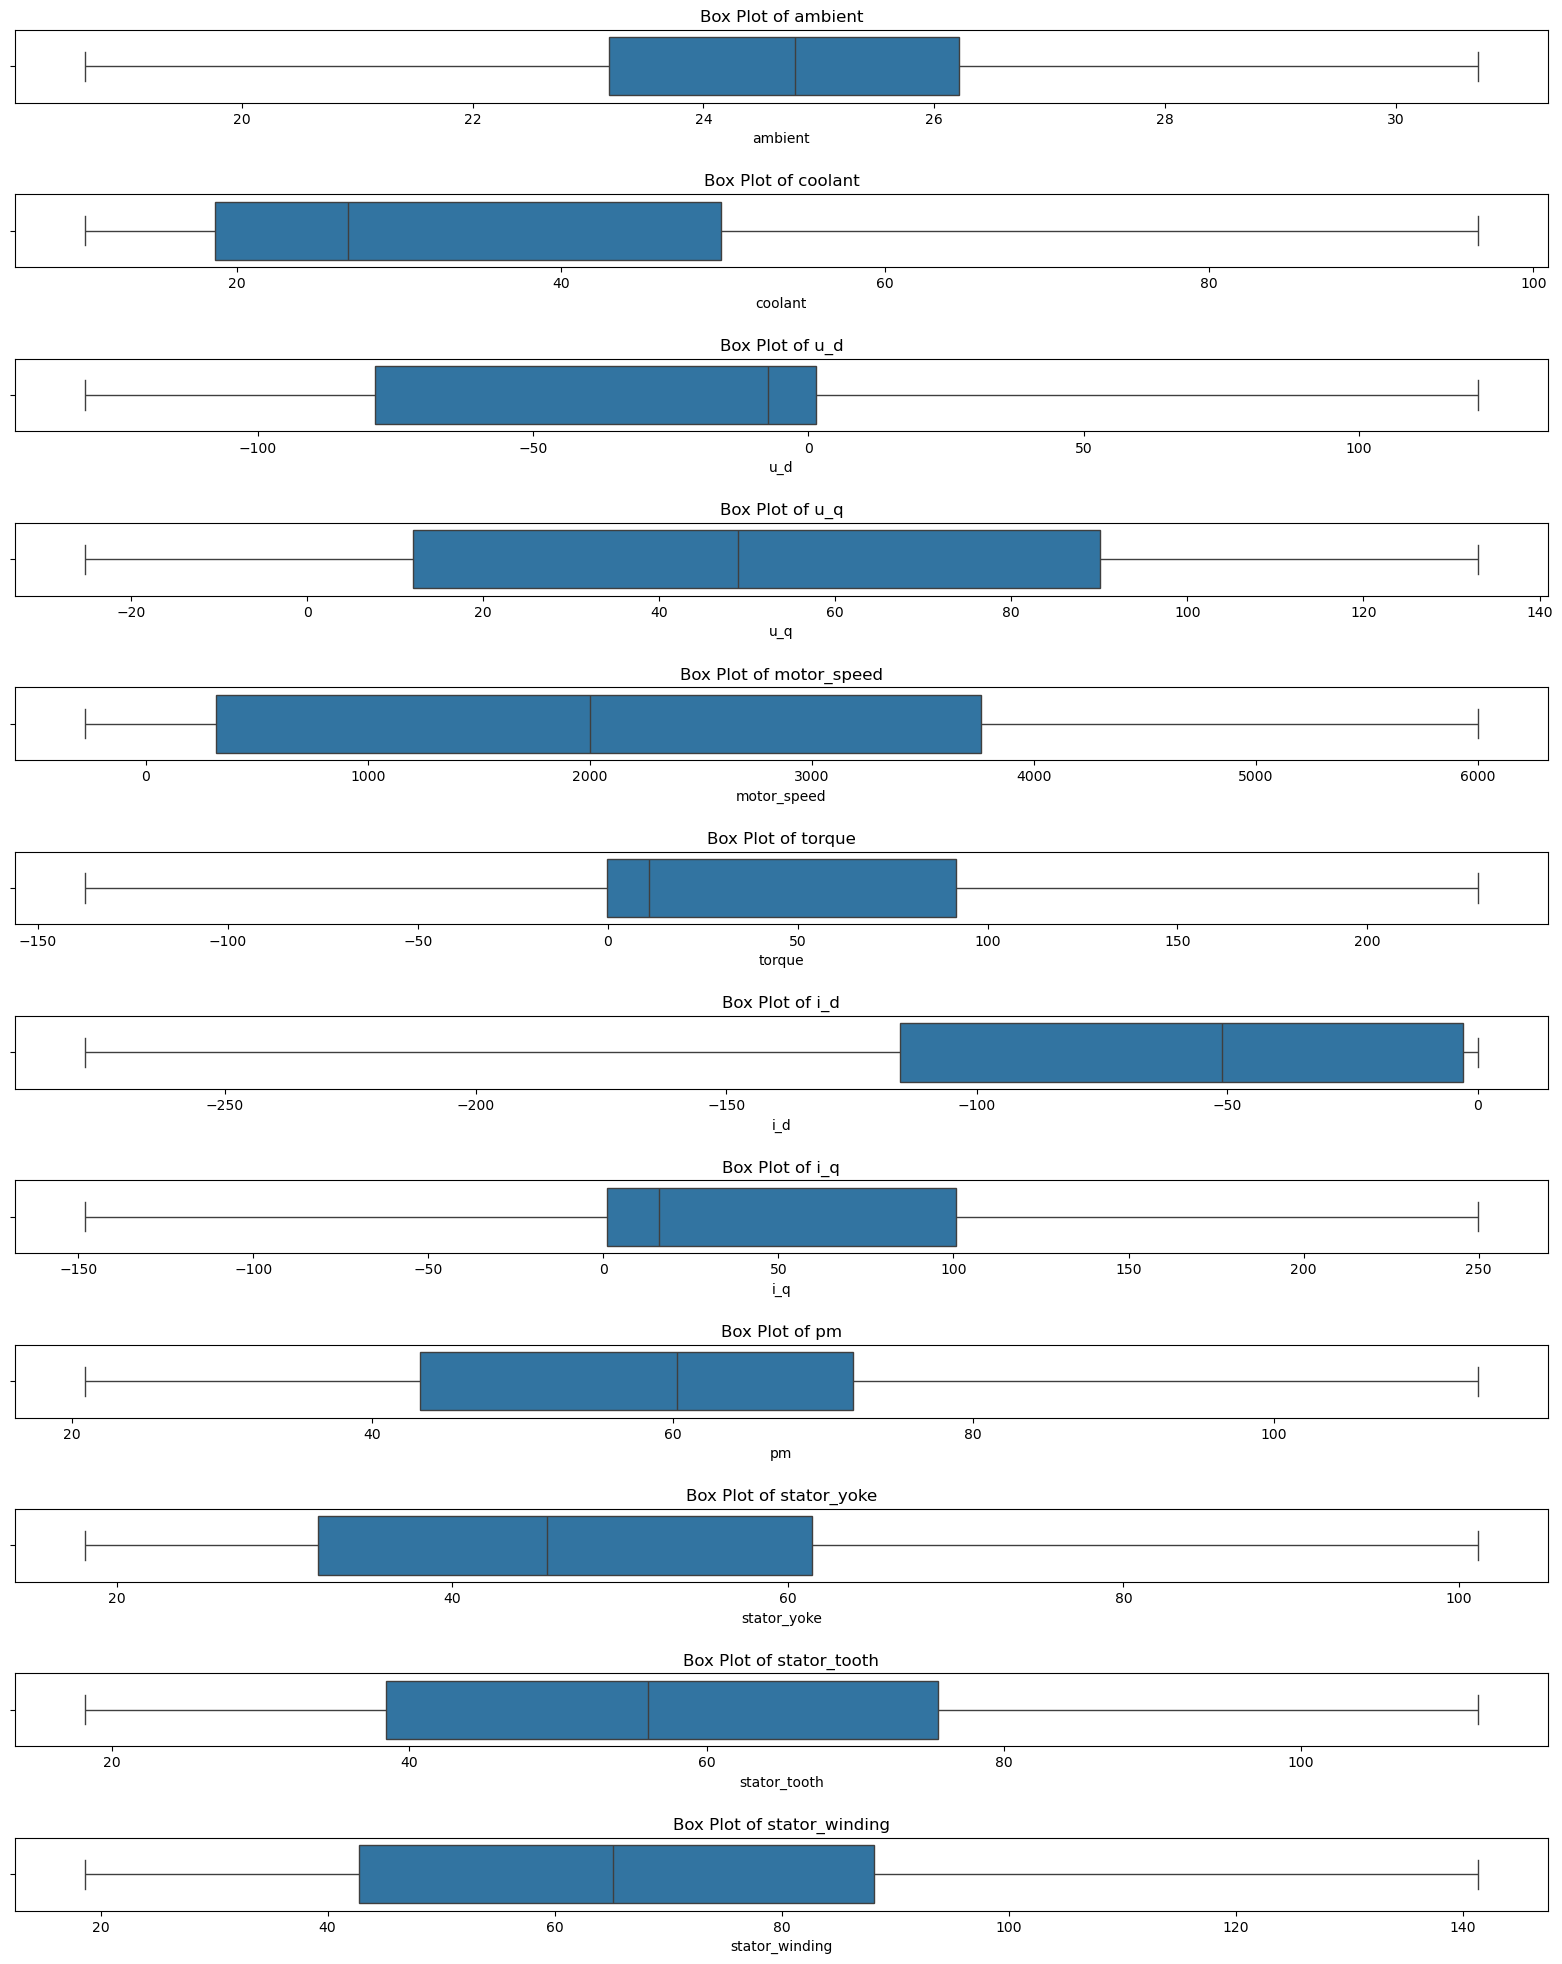

In [72]:
# Create subplots
fig, axes = plt.subplots(12, 1, figsize=(16, 20), sharex=False, sharey=False)

# Plot box plots for each column
sns.boxplot(x='ambient', data=df2, ax=axes[0])
sns.boxplot(x='coolant', data=df2, ax=axes[1])
sns.boxplot(x='u_d', data=df2, ax=axes[2])
sns.boxplot(x='u_q', data=df2, ax=axes[3])
sns.boxplot(x='motor_speed', data=df2, ax=axes[4])
sns.boxplot(x='torque', data=df2, ax=axes[5])
sns.boxplot(x='i_d', data=df2, ax=axes[6])
sns.boxplot(x='i_q', data=df2, ax=axes[7])
sns.boxplot(x='pm', data=df2, ax=axes[8])
sns.boxplot(x='stator_yoke', data=df2, ax=axes[9])
sns.boxplot(x='stator_tooth', data=df2, ax=axes[10])
sns.boxplot(x='stator_winding', data=df2, ax=axes[11])

# Add titles to subplots
axes[0].set_title('Box Plot of ambient', fontsize=12)
axes[1].set_title('Box Plot of coolant', fontsize=12)
axes[2].set_title('Box Plot of u_d', fontsize=12)
axes[3].set_title('Box Plot of u_q', fontsize=12)
axes[4].set_title('Box Plot of motor_speed', fontsize=12)
axes[5].set_title('Box Plot of torque', fontsize=12)
axes[6].set_title('Box Plot of i_d', fontsize=12)
axes[7].set_title('Box Plot of i_q', fontsize=12)
axes[8].set_title('Box Plot of pm', fontsize=12)
axes[9].set_title('Box Plot of stator_yoke', fontsize=12)
axes[10].set_title('Box Plot of stator_tooth', fontsize=12)
axes[11].set_title('Box Plot of stator_winding', fontsize=12)

# Adjust layout
plt.tight_layout(pad=2.0)
plt.show()

### Correlation matrix

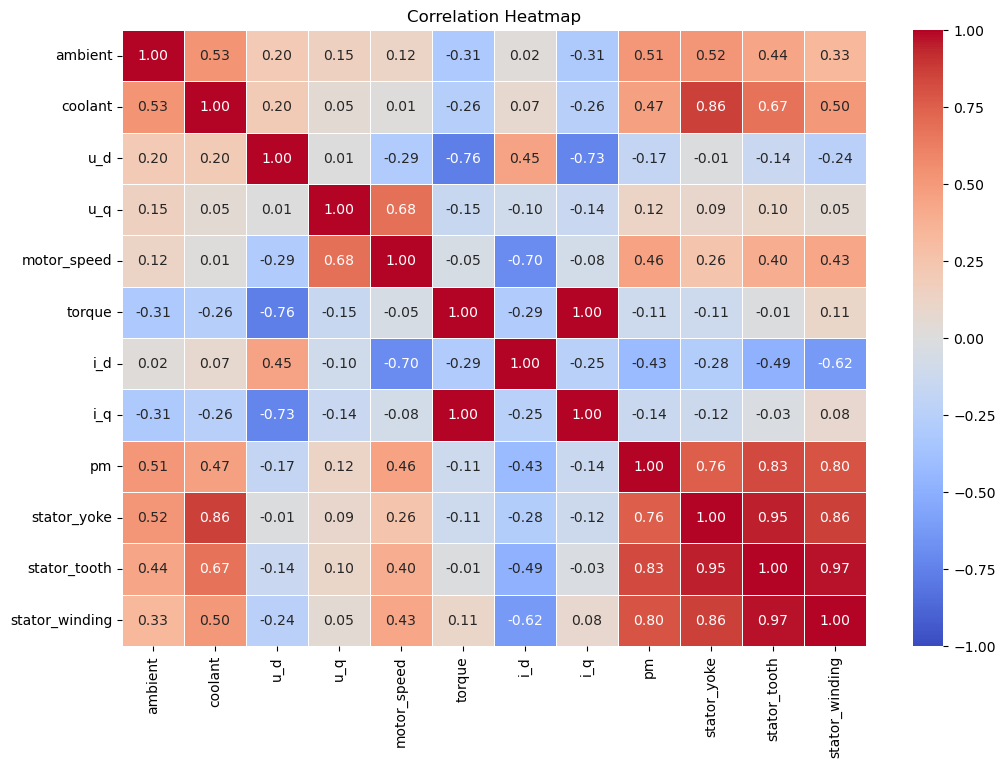

In [73]:
# Compute the correlation matrix
corr_matrix = df2.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Add title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [74]:
df2.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,2.456534e+01,3.622999e+01,-2.519414e+01,5.427900e+01,2.202081e+03,3.188851e+01,-6.871681e+01,3.874422e+01,5.850678e+01,4.818796e+01,5.687858e+01,6.634275e+01
std,1.929192e+00,2.178614e+01,6.294856e+01,4.417323e+01,1.859663e+03,7.436330e+01,6.493323e+01,8.719499e+01,1.900150e+01,1.999100e+01,2.295223e+01,2.867206e+01
min,1.863648e+01,1.062375e+01,-1.315304e+02,-2.529093e+01,-2.755491e+02,-1.377393e+02,-2.780036e+02,-1.481786e+02,2.085696e+01,1.807669e+01,1.813398e+01,1.858582e+01
25%,2.318480e+01,1.869814e+01,-7.869090e+01,1.206992e+01,3.171107e+02,-1.374265e-01,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,3.841601e+01,4.278796e+01
50%,2.479733e+01,2.690014e+01,-7.429755e+00,4.893818e+01,1.999977e+03,1.086035e+01,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,5.603635e+01,6.511013e+01
75%,2.621702e+01,4.985749e+01,1.470271e+00,9.003439e+01,3.760639e+03,9.159718e+01,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,7.558668e+01,8.814114e+01
max,3.071420e+01,9.659651e+01,1.217120e+02,1.330370e+02,6.000015e+03,2.291991e+02,5.189670e-02,2.498866e+02,1.136066e+02,1.011480e+02,1.119464e+02,1.413629e+02


### Variance Inflation Factor (VIF) To check Multicollinearity

#### What Happens if You Don’t Include a Constant?
If you exclude the constant, the regression model used for VIF calculation will force the intercept to be zero. This can lead to:

1.Incorrect VIF values.

2.Misinterpretation of multicollinearity.

3.Poor model performance.


In [75]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for a dataset
def calculate_vif(dataframe):
    # Exclude the target column ('motor_speed')
    independent_vars = dataframe.drop(columns=['motor_speed'])
    
    # Add a constant column for the intercept
    independent_vars['const'] = 1
    
    # Calculate VIF for each independent variable
    vif = pd.DataFrame()
    vif['Feature'] = independent_vars.columns
    vif['VIF'] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]
    
    return vif

# Assuming df, df1, and df2 are your datasets
# df: Original dataset
# df1: Dataset with outliers trimmed
# df2: Dataset with outliers capped

# Calculate VIF for each dataset
vif_df = calculate_vif(df)  # VIF for original dataset
vif_df1 = calculate_vif(df1)  # VIF for trimmed dataset
vif_df2 = calculate_vif(df2)  # VIF for capped dataset

# Rename VIF columns for clarity
vif_df = vif_df.rename(columns={'VIF': 'VIF_Original'}) 
vif_df1 = vif_df1.rename(columns={'VIF': 'VIF_Trimmed'})
vif_df2 = vif_df2.rename(columns={'VIF': 'VIF_Capped'})

# Combine the results into a single DataFrame for comparison
vif_comparison = vif_df.merge(vif_df1, on='Feature').merge(vif_df2, on='Feature')

vif_comparison

,Feature,VIF_Original,VIF_Trimmed,VIF_Capped
0,ambient,1.806307,1.769216,1.811519
1,coolant,43.781016,47.729837,44.363849
2,u_d,4.463308,5.035398,4.243756
3,u_q,1.685352,1.886770,1.647855
4,torque,289.707828,300.689448,190.163485
5,i_d,3.831214,4.816171,3.789180
6,i_q,256.988413,254.140737,170.777044
7,pm,6.644370,6.909347,6.675174
8,stator_yoke,444.144424,489.691949,452.937718
9,stator_tooth,850.925013,984.345156,868.911649


### Stator

What is Stator Winding?
The stator winding refers to the coils of wire wound around the stator (the stationary part of an electric motor).

When electric current flows through these windings, they generate a magnetic field, which interacts with the rotor (the rotating part) to produce motion (torque).

The temperature of the stator winding is measured because excessive heat can damage the insulation around the wires, leading to motor failure.

Stator contain all the Winding used to create rotating mangnetic feild when the lectricity is passed through the wires to power the coils we find an electric terminal box on the top

#### (pm) Permanent Magnet surface temperature representing the rotor temperature. 
#### This was measured with an infrared thermography unit.

In [76]:
%%html
<div style="display: flex; align-items: center; margin-bottom: 20px;">
    <!-- Left Image (infrared-themography.jpg) -->
    <img src="device.jpg" alt="Infrared Thermography" style="width: 500px; height: 350px; margin-right: 20px;">
    
    <!-- Right Image (device.jpg) -->
    <img src="infrared-themography.jpg" alt="Device" style="width: 500px; height: 350px;">
</div>

<!-- Text Below the Images -->
<div style="font-size: 16px; font-family: Arial, sans-serif; font-style: italic; color: #333; text-align: center;">
    <p>Infrared thermography is equipment or method, which detects infrared energy emitted from object, converts it to temperature, and displays image of temperature distribution.</p>
</div>

In [77]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define features and target
X = df2.drop(columns=['motor_speed'])
y = df2['motor_speed']

# Select top k features using ANOVA F-test
selector = SelectKBest(score_func=f_regression, k=10)  # Select top 5 features
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['ambient', 'u_d', 'u_q', 'torque', 'i_d', 'i_q', 'pm', 'stator_yoke',
       'stator_tooth', 'stator_winding'],
      dtype='object')


## RFE

In [78]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Separate features and target
X_rfe = df2.drop(columns=['motor_speed'])
y_rfe = df2['motor_speed']

# Initialize the model and RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
rfe.fit(X_rfe, y_rfe)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Get the ranking of features
feature_rankings = rfe.ranking_
print("Feature Rankings:", feature_rankings)

# Transform the dataset to include only selected features
X_selected = rfe.transform(X_rfe)

Selected Features: Index(['ambient', 'coolant', 'u_d', 'u_q', 'i_d', 'i_q', 'pm', 'stator_yoke',
       'stator_tooth', 'stator_winding'],
      dtype='object')
Feature Rankings: [1 1 1 1 2 1 1 1 1 1 1]


### Checking PPS Score

In [79]:
import ppscore as pps

# Drop the columns 
X_pps = df2.drop(columns=['motor_speed'])
y_pss = df2['motor_speed']


# Calculate PPS for each feature
pps_scores = pps.predictors(df2, y = "motor_speed")

# Display the PPS scores
pps_scores

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,i_q,motor_speed,0.507323,regression,True,mean absolute error,1598.886703,787.734051,DecisionTreeRegressor()
1,i_d,motor_speed,0.479174,regression,True,mean absolute error,1598.886703,832.741518,DecisionTreeRegressor()
2,torque,motor_speed,0.478619,regression,True,mean absolute error,1598.886703,833.629367,DecisionTreeRegressor()
3,u_q,motor_speed,0.471562,regression,True,mean absolute error,1598.886703,844.912331,DecisionTreeRegressor()
4,u_d,motor_speed,0.426618,regression,True,mean absolute error,1598.886703,916.773433,DecisionTreeRegressor()
5,ambient,motor_speed,0.000000,regression,True,mean absolute error,1598.886703,1997.906072,DecisionTreeRegressor()
6,coolant,motor_speed,0.000000,regression,True,mean absolute error,1598.886703,1810.459590,DecisionTreeRegressor()
7,pm,motor_speed,0.000000,regression,True,mean absolute error,1598.886703,1739.409418,DecisionTreeRegressor()
8,stator_yoke,motor_speed,0.000000,regression,True,mean absolute error,1598.886703,1673.730815,DecisionTreeRegressor()
9,stator_tooth,motor_speed,0.000000,regression,True,mean absolute error,1598.886703,1651.345738,DecisionTreeRegressor()


#### Was the Mean or Median Used?

From the ppscore documentation and typical implementations:

**The mean is usually used as the baseline prediction for regression tasks when calculating MAE. This is because the mean minimizes the MAE in the absence of any other information.**

Thus, it is highly likely that the naive model used the mean of the motor_speed column as the baseline prediction.

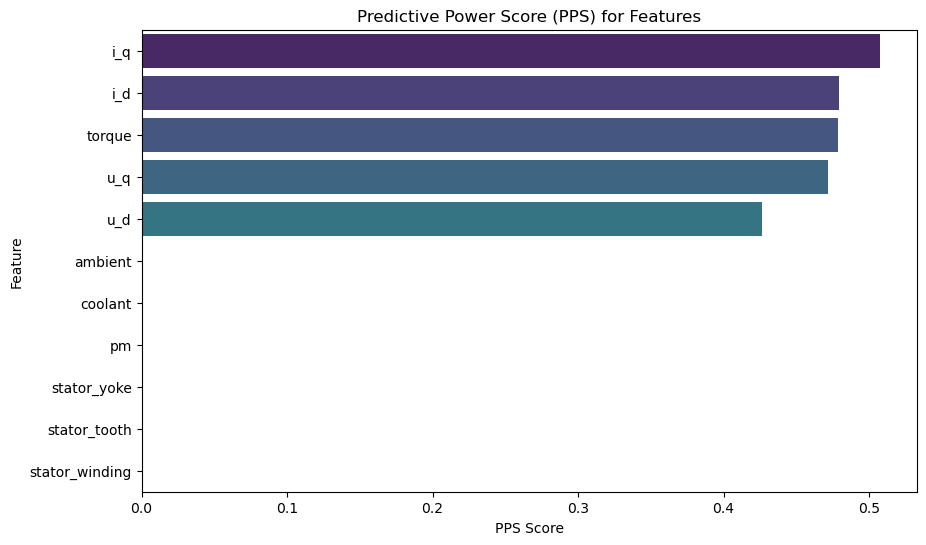

In [80]:
# Sort the PPS scores for better visualization
pps_scores_sorted = pps_scores.sort_values(by="ppscore", ascending=False)

# Plot the PPS scores
plt.figure(figsize=(10, 6))
sns.barplot(data=pps_scores_sorted, x="ppscore", y="x", hue="x", palette="viridis", legend=False)
plt.title("Predictive Power Score (PPS) for Features")
plt.xlabel("PPS Score")
plt.ylabel("Feature")
plt.show()

In [81]:
df2.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,0.187101,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,0.245417,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,0.176615,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,0.238303,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,0.208197,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525


## Random Forest

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

## for df2 DataFrame

In [101]:
# Step 1: Split the data into features (X) and target (y)
X_df2 = df2.drop(columns=['motor_speed'])  # Features
y_df2 = df2['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(X_df2, y_df2, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_df2 = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_df2 = scaler_df2.fit_transform(X_train_df2)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_df2 = scaler_df2.transform(X_test_df2)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_df2 = pd.DataFrame(X_train_scaled_df2, columns=X_train_df2.columns)
X_test_scaled_df2 = pd.DataFrame(X_test_scaled_df2, columns=X_test_df2.columns)

# Step 7: Initialize the Random Forest model
model_df2 = RandomForestRegressor(n_estimators=40, random_state=42, n_jobs=-1, oob_score=True)

# Step 8: Train the model
model_df2.fit(X_train_scaled_df2, y_train_df2)

# Step 9: Make predictions on testing data
y_test_pred_df2 = model_df2.predict(X_test_scaled_df2)  # Predictions on testing data

# Step 10: Evaluate the model on testing data
test_r2_df2 = r2_score(y_test_df2, y_test_pred_df2)
mse_df2 = mean_squared_error(y_test_df2, y_test_pred_df2)
rmse_df2 = mse_df2 ** 0.5

# Step 11: Print combined evaluation metrics
print(f"Testing R²: {test_r2_df2:.4f}, MSE: {mse_df2:.4f}, RMSE: {rmse_df2:.4f}")

Testing R²: 0.9999, MSE: 397.2961, RMSE: 19.9323


##### ****A R² value this high suggests that the model is overfitting the data. Overfitting occurs when the model learns the training data too well, including noise and outliers, and performs poorly on unseen data.****

##### ****The MSE value of 397.2961 seems high, but its interpretation depends on the scale of the target variable (motor_speed). If the target variable has a large range (e.g., values in the thousands), this MSE might be acceptable. If the target variable has a small range (e.g., values between 0 and 1), this MSE is very high.****

##### ****The RMSE value of 19.9323 suggests that, on average, the model's predictions are off by approximately 19.93 units from the actual values.****

In [102]:
# Step 12: Create a DataFrame for actual vs predicted values
results_df2 = pd.DataFrame({
    'Actual': y_test_df2,
    'Predicted': y_test_pred_df2
})

print("Actual vs Predicted for df2:")
results_df2

Actual vs Predicted for df2:


,Actual,Predicted
294684,4999.950684,4999.943542
668769,4999.958502,4999.961444
1326035,4576.694931,4562.489388
879218,501.136705,501.420651
75406,4499.962891,4499.960925
...,...,...
448264,419.992126,419.990455
651840,1437.928544,1448.396235
528518,1249.995605,1249.989215
977974,2756.324859,2762.131831


In [103]:
oob_score_df2 = model_df2.oob_score_
print(f"OOB Score: {oob_score_df2:.4f}")

OOB Score: 0.9999


## Homoscedasticity and Heteroscedasticity

In [126]:
residuals_df2 = y_test_df2 - y_test_pred_df2   #for df2


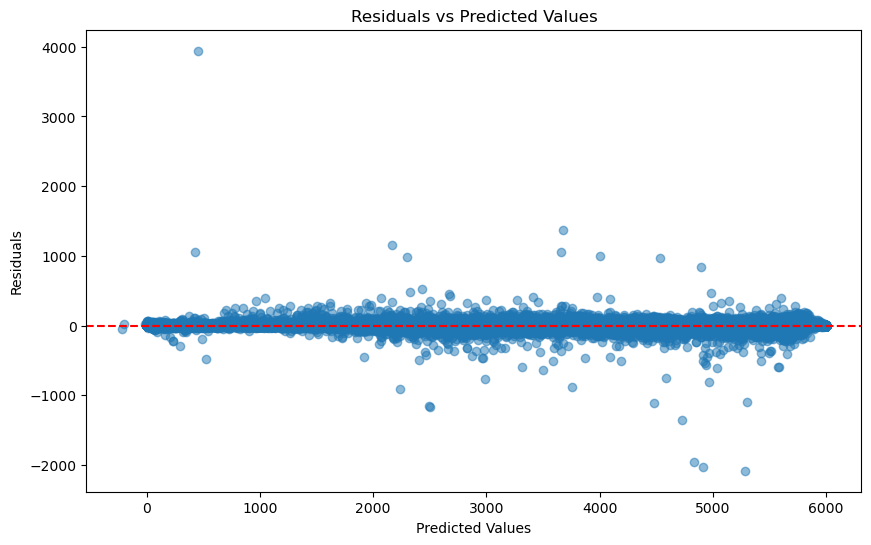

In [127]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_df2, residuals_df2, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

#### X-axis (Predicted Values): This axis represents the predicted values from your regression model (y_pred_df2). The range of predicted values is from 0 to 6000. (because of wide range of motor speed)

#### Y-axis (Residuals): This axis represents the residuals, which are the differences between the actual values (y_test_df2) and the predicted values (y_pred_df2). The range of residuals is from -2000 to 4000.

#### Horizontal Red Line (y=0): This line represents the point where residuals are zero, meaning the predicted values perfectly match the actual values.

##### If the residuals are randomly distributed without any clear pattern, it suggests *homoscedasticity*. This means the variance of the residuals is constant across all levels of the predicted values.

##### |If the residuals show a systematic pattern, such as a funnel shape (residuals spreading out as predicted values increase or decrease), it suggests *heteroscedasticity*. This means the variance of the residuals is not constant.

#### *Based on the description, if the residuals are randomly scattered around the horizontal red line without any clear pattern, it indicates homoscedasticity. This is a good sign, as it suggests that your model's errors are consistent across all levels of the predicted values.*

## Hyperparameter Tuning Tips

Algorithms and Scaling Requirements:
Algorithm	Scaling Requirement
Decision Tree (DT)	No scaling needed. Trees are invariant to feature scaling.
Random Forest (RF)	No scaling needed. Trees are invariant to feature scaling.
k-Nearest Neighbors (k-NN)	Scaling is critical. Distance-based algorithms are sensitive to feature scales.
Linear Regression	Scaling is recommended, especially if using regularization (e.g., Ridge, Lasso).
Neural Networks	Scaling is critical. Ensures faster convergence and better performance.
LightGBM	No scaling needed. Trees are invariant to feature scaling.

##  RF for df DataFrame


In [104]:
# Step 1: Split the data into features (X) and target (y)
X_df = df.drop(columns=['motor_speed'])  # Features
y_df = df['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_df = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_df = scaler_df.fit_transform(X_train_df)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_df = scaler_df.transform(X_test_df)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_df = pd.DataFrame(X_train_scaled_df, columns=X_train_df.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled_df, columns=X_test_df.columns)

# Step 7: Initialize the Random Forest model
model_df = RandomForestRegressor(n_estimators=40, random_state=42, n_jobs=-1, oob_score=True)

# Step 8: Train the model
model_df.fit(X_train_scaled_df, y_train_df)

# Step 9: Make predictions on testing data
y_test_pred_df = model_df.predict(X_test_scaled_df)  # Predictions on testing data

# Step 10: Evaluate the model on testing data
test_r2_df = r2_score(y_test_df, y_test_pred_df)
mse_df = mean_squared_error(y_test_df, y_test_pred_df)
rmse_df = mse_df ** 0.5

# Step 11: Print combined evaluation metrics
print(f"Testing R² for df: {test_r2_df:.4f}, MSE: {mse_df:.4f}, RMSE: {rmse_df:.4f}")

Testing R² for df: 0.9999, MSE: 380.9931, RMSE: 19.5190


## For df1 Dataframe:

In [105]:
# Step 1: Split the data into features (X) and target (y)
X_df1 = df1.drop(columns=['motor_speed'])  # Features
y_df1 = df1['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(X_df1, y_df1, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_df1 = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_df1 = scaler_df1.fit_transform(X_train_df1)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_df1 = scaler_df1.transform(X_test_df1)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_df1 = pd.DataFrame(X_train_scaled_df1, columns=X_train_df1.columns)
X_test_scaled_df1 = pd.DataFrame(X_test_scaled_df1, columns=X_test_df1.columns)

# Step 7: Initialize the Random Forest model
model_df1 = RandomForestRegressor(n_estimators=40, random_state=42, n_jobs=-1, oob_score=True)

# Step 8: Train the model
model_df1.fit(X_train_scaled_df1, y_train_df1)

# Step 9: Make predictions on testing data
y_test_pred_df1 = model_df1.predict(X_test_scaled_df1)  # Predictions on testing data

# Step 10: Evaluate the model on testing data
test_r2_df1 = r2_score(y_test_df1, y_test_pred_df1)
mse_df1 = mean_squared_error(y_test_df1, y_test_pred_df1)
rmse_df1 = mse_df1 ** 0.5

# Step 11: Print combined evaluation metrics
print(f"Testing R² for df1: {test_r2_df1:.4f}, MSE: {mse_df1:.4f}, RMSE: {rmse_df1:.4f}")

Testing R² for df1: 0.9999, MSE: 326.5731, RMSE: 18.0713


In [ ]:
## Homoscedasticity and Heteroscedasticity


#residuals_df2 = y_test_df1 - y_test_pred_df1  # for df1

## Evaluate the model on both training and testing data

## For df dataframe

In [106]:
# Step 1: Make predictions on training data
y_train_pred_df = model_df.predict(X_train_scaled_df)

# Step 2: Evaluate the model on training data
train_r2_df = r2_score(y_train_df, y_train_pred_df)
train_mse_df = mean_squared_error(y_train_df, y_train_pred_df)
train_rmse_df = train_mse_df ** 0.5

# Step 3: Print training evaluation metrics
print("Training Metrics for df:")
print(f"Training R²: {train_r2_df:.4f}, MSE: {train_mse_df:.4f}, RMSE: {train_rmse_df:.4f}")

# Step 4: Print testing evaluation metrics (already calculated)
print("Testing Metrics for df:")
print(f"Testing R²: {test_r2_df:.4f}, MSE: {mse_df:.4f}, RMSE: {rmse_df:.4f}")

Training Metrics for df:
Training R²: 1.0000, MSE: 56.8684, RMSE: 7.5411
Testing Metrics for df:
Testing R²: 0.9999, MSE: 380.9931, RMSE: 19.5190


## For df1 dataframe

In [107]:
# Step 1: Make predictions on training data
y_train_pred_df1 = model_df1.predict(X_train_scaled_df1)

# Step 2: Evaluate the model on training data
train_r2_df1 = r2_score(y_train_df1, y_train_pred_df1)
train_mse_df1 = mean_squared_error(y_train_df1, y_train_pred_df1)
train_rmse_df1 = train_mse_df1 ** 0.5

# Step 3: Print training evaluation metrics
print("Training Metrics for df1:")
print(f"Training R²: {train_r2_df1:.4f}, MSE: {train_mse_df1:.4f}, RMSE: {train_rmse_df1:.4f}")

# Step 4: Print testing evaluation metrics (already calculated)
print("Testing Metrics for df1:")
print(f"Testing R²: {test_r2_df1:.4f}, MSE: {mse_df1:.4f}, RMSE: {rmse_df1:.4f}")

Training Metrics for df1:
Training R²: 1.0000, MSE: 60.4257, RMSE: 7.7734
Testing Metrics for df1:
Testing R²: 0.9999, MSE: 326.5731, RMSE: 18.0713


## for df2 DataFrame

In [108]:
# Step 1: Make predictions on training data
y_train_pred_df2 = model_df2.predict(X_train_scaled_df2)

# Step 2: Evaluate the model on training data
train_r2_df2 = r2_score(y_train_df2, y_train_pred_df2)
train_mse_df2 = mean_squared_error(y_train_df2, y_train_pred_df2)
train_rmse_df2 = train_mse_df2 ** 0.5

# Step 3: Print training evaluation metrics
print("Training Metrics for df2:")
print(f"Training R²: {train_r2_df2:.4f}, MSE: {train_mse_df2:.4f}, RMSE: {train_rmse_df2:.4f}")

# Step 4: Print testing evaluation metrics (already calculated)
print("Testing Metrics for df2:")
print(f"Testing R²: {test_r2_df2:.4f}, MSE: {mse_df2:.4f}, RMSE: {rmse_df2:.4f}")

Training Metrics for df2:
Training R²: 1.0000, MSE: 60.1049, RMSE: 7.7527
Testing Metrics for df2:
Testing R²: 0.9999, MSE: 397.2961, RMSE: 19.9323


In [ ]:
#model_df = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42, n_jobs=-1)

## Neural Network (Rince)

#### For df1 Dataframe

In [86]:
# Splitting features and target for df1
X_nn_df1 = df1.drop(columns=['motor_speed'])  # Features from df1
y_nn_df1 = df1['motor_speed']  # Target from df1

# Train-Test Split for df1
X_train_nn_df1, X_test_nn_df1, y_train_nn_df1, y_test_nn_df1 = train_test_split(X_nn_df1, y_nn_df1, test_size=0.2, random_state=42)

# Standardize the data for df1
scaler_nn_df1 = StandardScaler()
X_train_scaled_nn_df1 = scaler_nn_df1.fit_transform(X_train_nn_df1)
X_test_scaled_nn_df1 = scaler_nn_df1.transform(X_test_nn_df1)

# Function to create the neural network model
def create_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and evaluate for df1
model_nn_df1 = create_model(X_train_scaled_nn_df1.shape[1])
history_nn_df1 = model_nn_df1.fit(X_train_scaled_nn_df1, y_train_nn_df1, validation_data=(X_test_scaled_nn_df1, y_test_nn_df1), epochs=20, batch_size=32)

# Predict and evaluate for df1
y_pred_nn_df1 = model_nn_df1.predict(X_test_scaled_nn_df1).flatten()  # Flatten the predictions

# Compute Metrics for df1
mse_nn_df1 = mean_squared_error(y_test_nn_df1, y_pred_nn_df1)
rmse_nn_df1 = mse_nn_df1 ** 0.5
r2_nn_df1 = r2_score(y_test_nn_df1, y_pred_nn_df1)

# Print Results for df1
print("Results for Neural Network Model (using df1):")
print(f"MSE: {mse_nn_df1}")
print(f"RMSE: {rmse_nn_df1}")
print(f"R² Score: {r2_nn_df1}")

Epoch 1/20
31580/31580 [==============================] - 46s 1ms/step - loss: 101408.3125 - mae: 179.1485 - val_loss: 24723.7520 - val_mae: 119.6527
Epoch 2/20
31580/31580 [==============================] - 53s 2ms/step - loss: 34177.8320 - mae: 117.3753 - val_loss: 34468.5469 - val_mae: 138.5346
Epoch 3/20
31580/31580 [==============================] - 55s 2ms/step - loss: 24822.5801 - mae: 99.1952 - val_loss: 68579.1953 - val_mae: 221.3893
Epoch 4/20
31580/31580 [==============================] - 55s 2ms/step - loss: 16921.9004 - mae: 80.3757 - val_loss: 107018.4922 - val_mae: 265.6161
Epoch 5/20
31580/31580 [==============================] - 61s 2ms/step - loss: 13223.9395 - mae: 70.6376 - val_loss: 95449.9688 - val_mae: 257.1326
Epoch 6/20
31580/31580 [==============================] - 59s 2ms/step - loss: 10957.4424 - mae: 64.0891 - val_loss: 121299.4219 - val_mae: 288.8319
Epoch 7/20
31580/31580 [==============================] - 50s 2ms/step - loss: 9475.8447 - mae: 59.9591 - v

#### For df2 Dataframe

In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Splitting features and target
X_nn_df2 = df2.drop(columns=['motor_speed'])  # Features from df2
y_nn_df2 = df2['motor_speed']  # Target from df2

# Train-Test Split
X_train_nn_df2, X_test_nn_df2, y_train_nn_df2, y_test_nn_df2 = train_test_split(X_nn_df2, y_nn_df2, test_size=0.2, random_state=42)

# Standardize the data
scaler_nn_df2 = StandardScaler()
X_train_scaled_nn_df2 = scaler_nn_df2.fit_transform(X_train_nn_df2)
X_test_scaled_nn_df2 = scaler_nn_df2.transform(X_test_nn_df2)

# Function to create the neural network model
def create_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and evaluate for df2
model_nn_df2 = create_model(X_train_scaled_nn_df2.shape[1])
history_nn_df2 = model_nn_df2.fit(X_train_scaled_nn_df2, y_train_nn_df2, validation_data=(X_test_scaled_nn_df2, y_test_nn_df2), epochs=20, batch_size=32)

# Predict and evaluate
y_pred_nn_df2 = model_nn_df2.predict(X_test_scaled_nn_df2).flatten()  # Flatten the predictions

# Compute Metrics
mse_nn_df2 = mean_squared_error(y_test_nn_df2, y_pred_nn_df2)
rmse_nn_df2 = mse_nn_df2 ** 0.5
r2_nn_df2 = r2_score(y_test_nn_df2, y_pred_nn_df2)

# Print Results
print("Results for Neural Network Model (using df2):")
print(f"MSE: {mse_nn_df2}")
print(f"RMSE: {rmse_nn_df2}")
print(f"R² Score: {r2_nn_df2}")

Epoch 1/20
33271/33271 [==============================] - 54s 2ms/step - loss: 110360.5000 - mae: 197.2875 - val_loss: 10201.9971 - val_mae: 57.0661
Epoch 2/20
33271/33271 [==============================] - 54s 2ms/step - loss: 52542.2852 - mae: 154.0498 - val_loss: 14598.9268 - val_mae: 85.3784
Epoch 3/20
33271/33271 [==============================] - 54s 2ms/step - loss: 41189.9922 - mae: 135.2017 - val_loss: 79095.7812 - val_mae: 202.9165
Epoch 4/20
33271/33271 [==============================] - 55s 2ms/step - loss: 29971.6504 - mae: 113.3559 - val_loss: 100642.9609 - val_mae: 226.8092
Epoch 5/20
33271/33271 [==============================] - 56s 2ms/step - loss: 23948.5293 - mae: 99.9212 - val_loss: 129169.9609 - val_mae: 256.1025
Epoch 6/20
33271/33271 [==============================] - 54s 2ms/step - loss: 18573.5742 - mae: 86.4545 - val_loss: 139300.6250 - val_mae: 269.7270
Epoch 7/20
33271/33271 [==============================] - 53s 2ms/step - loss: 15032.1270 - mae: 75.8716 -

## MLR (Shifa)

### For df1

In [88]:
from sklearn.linear_model import LinearRegression


# Separate features (X_LR_df1) and target variable (y_LR_df1) for df1
X_LR_df1 = df1.drop(columns=['motor_speed'])  # Features (all columns except 'motor_speed')
y_LR_df1 = df1['motor_speed']  # Target variable

# Standardize the features for df1
scaler_df1 = StandardScaler()
X_LR_scaled_df1 = scaler_df1.fit_transform(X_LR_df1)  # Fit and transform the features

# Split the data into training and testing sets for df1
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(X_LR_scaled_df1, y_LR_df1, test_size=0.2, random_state=42)

# Train the linear regression model for df1
model_lr_df1 = LinearRegression()
model_lr_df1.fit(X_train_df1, y_train_df1)

# Make predictions for df1
y_pred_df1 = model_lr_df1.predict(X_test_df1)

# Evaluate the model for df1
mse_LR_df1 = mean_squared_error(y_test_df1, y_pred_df1)
r2_LR_df1 = r2_score(y_test_df1, y_pred_df1)
rmse_LR_df1 = np.sqrt(mse_LR_df1)

# Print the results for df1
print(f"Mean Squared Error (df1): {mse_LR_df1}")
print(f"R-squared (df1): {r2_LR_df1}")
print(f"Root Mean Squared Error (df1): {rmse_LR_df1}")

Mean Squared Error (df1): 127184.63162917124
R-squared (df1): 0.9642626551866696
Root Mean Squared Error (df1): 356.6295439656833


### for df2

In [89]:
# Separate features (X_LR_df2) and target variable (y_LR_df2) for df2
X_LR_df2 = df2.drop(columns=['motor_speed'])  # Features (all columns except 'motor_speed')
y_LR_df2 = df2['motor_speed']  # Target variable

# Standardize the features for df2
scaler_df2 = StandardScaler()
X_LR_scaled_df2 = scaler_df2.fit_transform(X_LR_df2)  # Fit and transform the features

# Split the data into training and testing sets for df2
X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(X_LR_scaled_df2, y_LR_df2, test_size=0.2, random_state=42)

# Train the linear regression model for df2
model_lr_df2 = LinearRegression()
model_lr_df2.fit(X_train_df2, y_train_df2)

# Make predictions for df2
y_pred_df2 = model_lr_df2.predict(X_test_df2)

# Evaluate the model for df2
mse_LR_df2 = mean_squared_error(y_test_df2, y_pred_df2)
r2_LR_df2 = r2_score(y_test_df2, y_pred_df2)
rmse_LR_df2 = np.sqrt(mse_LR_df2)

# Print the results for df2
print(f"Mean Squared Error (df2): {mse_LR_df2}")
print(f"R-squared (df2): {r2_LR_df2}")
print(f"Root Mean Squared Error (df2): {rmse_LR_df2}")

Mean Squared Error (df2): 206236.62660175675
R-squared (df2): 0.9402953070116199
Root Mean Squared Error (df2): 454.13282924906093


## Decision Tree (Ritesh)

In [109]:
from sklearn.tree import DecisionTreeRegressor

# Step 1: Split the data into features (X_DT) and target (y_DT)
X_DT = df2.drop(columns=['motor_speed'])  # Features
y_DT = df2['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_DT = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_DT = scaler_DT.fit_transform(X_train_DT)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_DT = scaler_DT.transform(X_test_DT)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_DT = pd.DataFrame(X_train_scaled_DT, columns=X_train_DT.columns)
X_test_scaled_DT = pd.DataFrame(X_test_scaled_DT, columns=X_test_DT.columns)

# Step 7: Initialize the Decision Tree model
dt_model_DT = DecisionTreeRegressor(random_state=42)

# Step 8: Train the model
dt_model_DT.fit(X_train_scaled_DT, y_train_DT)

# Step 9: Make predictions on testing data
y_test_pred_DT = dt_model_DT.predict(X_test_scaled_DT)

# Step 10: Evaluate the model on testing data
test_r2_DT = r2_score(y_test_DT, y_test_pred_DT)
mse_DT = mean_squared_error(y_test_DT, y_test_pred_DT)
rmse_DT = mse_DT ** 0.5

# Step 11: Print combined evaluation metrics
print(f"Decision Tree Testing R²: {test_r2_DT:.4f}, MSE: {mse_DT:.4f}, RMSE: {rmse_DT:.4f}")



Decision Tree Testing R²: 0.9998, MSE: 818.6766, RMSE: 28.6125


## Hyperparameter Tuning 

#### Grid Search Cross Validation (GridSearchCV)

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]  # 'auto' is not valid for DecisionTreeRegressor
}

# Initialize Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
                           scoring='r2', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train_scaled_df2, y_train_df2)

# Best estimator from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions using the best model
y_pred = best_model.predict(X_test_scaled_df2)

# Calculate R², MSE, and RMSE
test_r2_gscv = r2_score(y_test_df2, y_pred)
mse_gscv = mean_squared_error(y_test_df2, y_pred)
rmse_gscv = np.sqrt(mse_gscv)

# Print results
print(f"Best Parameters (GridSearchCV): {grid_search.best_params_}")
print(f"Best R² Score (GridSearchCV): {grid_search.best_score_:.4f}")
print(f"GridSearchCV Decision Tree Testing R²: {test_r2_gscv:.4f}, MSE: {mse_gscv:.4f}, RMSE: {rmse_gscv:.4f}")


#### BayesSearchCV

In [ ]:
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define search space
search_space = {
    'max_depth': (5, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': ['sqrt', 'log2', None]  # 'auto' is not valid for DecisionTreeRegressor
}

# Initialize Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# BayesSearchCV
bayes_search = BayesSearchCV(estimator=dt_model, search_spaces=search_space, 
                             n_iter=20, cv=5, scoring='r2', n_jobs=-1, verbose=2, random_state=42)

# Fit the model
bayes_search.fit(X_train_scaled_df2, y_train_df2)

# Best estimator from BayesSearchCV
best_model = bayes_search.best_estimator_

# Predictions using the best model
y_pred = best_model.predict(X_test_scaled_df2)

# Calculate R², MSE, and RMSE
test_r2_bayes = r2_score(y_test_df2, y_pred)
mse_bayes = mean_squared_error(y_test_df2, y_pred)
rmse_bayes = np.sqrt(mse_bayes)

# Print results
print(f"Best Parameters (BayesSearchCV): {bayes_search.best_params_}")
print(f"Best R² Score (BayesSearchCV): {bayes_search.best_score_:.4f}")
print(f"BayesSearchCV Decision Tree Testing R²: {test_r2_bayes:.4f}, MSE: {mse_bayes:.4f}, RMSE: {rmse_bayes:.4f}")


### Building DT model using best parameters

In [110]:
# Initialize the Final Decision Tree model with best parameters
final_model_df2 = DecisionTreeRegressor(max_depth=49, max_features=None, min_samples_leaf=3, min_samples_split=2, random_state=42)

#  Train the final model
final_model_df2.fit(X_train_scaled_DT, y_train_DT)

#  Make predictions on testing data
y_test_pred_final_df2 = final_model_df2.predict(X_test_scaled_DT)

#  Evaluate the final model on testing data
test_r2_final_df2 = r2_score(y_test_DT, y_test_pred_final_df2)
mse_final_df2 = mean_squared_error(y_test_DT, y_test_pred_final_df2)
rmse_final_df2 = mse_final_df2 ** 0.5

#  Print combined evaluation metrics

print(f"Final Decision Tree Model Testing R²: {test_r2_final_df2:.4f}")
print(f"MSE: {mse_final_df2:.4f}")
print(f"RMSE: {rmse_final_df2:.4f}")

Final Decision Tree Model Testing R²: 0.9998
MSE: 845.4865
RMSE: 29.0772


### Madhu (XGBOOST)

### for df1 

In [92]:
from xgboost import XGBRegressor

# Step 1: Split the data into features (X_XGB_df1) and target (y_XGB_df1)
X_XGB_df1 = df1.drop(columns=['motor_speed'])  # Features
y_XGB_df1 = df1['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_XGB_df1, X_test_XGB_df1, y_train_XGB_df1, y_test_XGB_df1 = train_test_split(X_XGB_df1, y_XGB_df1, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_XGB_df1 = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_XGB_df1 = scaler_XGB_df1.fit_transform(X_train_XGB_df1)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_XGB_df1 = scaler_XGB_df1.transform(X_test_XGB_df1)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_XGB_df1 = pd.DataFrame(X_train_scaled_XGB_df1, columns=X_train_XGB_df1.columns)
X_test_scaled_XGB_df1 = pd.DataFrame(X_test_scaled_XGB_df1, columns=X_test_XGB_df1.columns)

# Step 7: Initialize the XGBoost model
xgb_model_df1 = XGBRegressor(random_state=42)

# Step 8: Train the model
xgb_model_df1.fit(X_train_scaled_XGB_df1, y_train_XGB_df1)

# Step 9: Make predictions on testing data
y_test_pred_XGB_df1 = xgb_model_df1.predict(X_test_scaled_XGB_df1)

# Step 10: Evaluate the model on testing data
test_r2_XGB_df1 = r2_score(y_test_XGB_df1, y_test_pred_XGB_df1)
mse_XGB_df1 = mean_squared_error(y_test_XGB_df1, y_test_pred_XGB_df1)
rmse_XGB_df1 = mse_XGB_df1 ** 0.5

# Step 11: Print combined evaluation metrics on separate lines
print(f"XGBoost Testing R² (df1): {test_r2_XGB_df1:.4f}")
print(f"MSE (df1): {mse_XGB_df1:.4f}")
print(f"RMSE (df1): {rmse_XGB_df1:.4f}")

XGBoost Testing R² (df1): 0.9997
MSE (df1): 1038.4105
RMSE (df1): 32.2244


### for df2 

In [93]:
# Step 1: Split the data into features (X_XGB_df2) and target (y_XGB_df2)
X_XGB_df2 = df2.drop(columns=['motor_speed'])  # Features
y_XGB_df2 = df2['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_XGB_df2, X_test_XGB_df2, y_train_XGB_df2, y_test_XGB_df2 = train_test_split(X_XGB_df2, y_XGB_df2, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_XGB_df2 = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_XGB_df2 = scaler_XGB_df2.fit_transform(X_train_XGB_df2)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_XGB_df2 = scaler_XGB_df2.transform(X_test_XGB_df2)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_XGB_df2 = pd.DataFrame(X_train_scaled_XGB_df2, columns=X_train_XGB_df2.columns)
X_test_scaled_XGB_df2 = pd.DataFrame(X_test_scaled_XGB_df2, columns=X_test_XGB_df2.columns)

# Step 7: Initialize the XGBoost model
xgb_model_df2 = XGBRegressor(random_state=42)

# Step 8: Train the model
xgb_model_df2.fit(X_train_scaled_XGB_df2, y_train_XGB_df2)

# Step 9: Make predictions on testing data
y_test_pred_XGB_df2 = xgb_model_df2.predict(X_test_scaled_XGB_df2)

# Step 10: Evaluate the model on testing data
test_r2_XGB_df2 = r2_score(y_test_XGB_df2, y_test_pred_XGB_df2)
mse_XGB_df2 = mean_squared_error(y_test_XGB_df2, y_test_pred_XGB_df2)
rmse_XGB_df2 = mse_XGB_df2 ** 0.5

# Step 11: Print combined evaluation metrics on separate lines
print(f"XGBoost Testing R² (df2): {test_r2_XGB_df2:.4f}")
print(f"MSE (df2): {mse_XGB_df2:.4f}")
print(f"RMSE (df2): {rmse_XGB_df2:.4f}")

XGBoost Testing R² (df2): 0.9996
MSE (df2): 1228.9573
RMSE (df2): 35.0565


## KNN

## for df1

In [96]:
# Step 1: Split the data into features (X_KNN_df1) and target (y_KNN_df1)
X_KNN_df1 = df1.drop(columns=['motor_speed'])  # Features
y_KNN_df1 = df1['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_KNN_df1, X_test_KNN_df1, y_train_KNN_df1, y_test_KNN_df1 = train_test_split(X_KNN_df1, y_KNN_df1, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_KNN_df1 = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_KNN_df1 = scaler_KNN_df1.fit_transform(X_train_KNN_df1)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_KNN_df1 = scaler_KNN_df1.transform(X_test_KNN_df1)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_KNN_df1 = pd.DataFrame(X_train_scaled_KNN_df1, columns=X_train_KNN_df1.columns)
X_test_scaled_KNN_df1 = pd.DataFrame(X_test_scaled_KNN_df1, columns=X_test_KNN_df1.columns)

# Step 7: Initialize the KNN model
knn_model_df1 = KNeighborsRegressor(n_neighbors=5)  # You can adjust n_neighbors as needed

# Step 8: Train the model
knn_model_df1.fit(X_train_scaled_KNN_df1, y_train_KNN_df1)

# Step 9: Make predictions on testing data
y_test_pred_KNN_df1 = knn_model_df1.predict(X_test_scaled_KNN_df1)

# Step 10: Evaluate the model on testing data
test_r2_KNN_df1 = r2_score(y_test_KNN_df1, y_test_pred_KNN_df1)
mse_KNN_df1 = mean_squared_error(y_test_KNN_df1, y_test_pred_KNN_df1)
rmse_KNN_df1 = mse_KNN_df1 ** 0.5

# Step 11: Print combined evaluation metrics on separate lines
print(f"KNN Testing R² (df1): {test_r2_KNN_df1:.4f}")
print(f"MSE (df1): {mse_KNN_df1:.4f}")
print(f"RMSE (df1): {rmse_KNN_df1:.4f}")

KNN Testing R² (df1): 0.9994
MSE (df1): 2247.2743
RMSE (df1): 47.4054


## for df2

In [95]:
from sklearn.neighbors import KNeighborsRegressor

# Step 1: Split the data into features (X_KNN_df2) and target (y_KNN_df2)
X_KNN_df2 = df2.drop(columns=['motor_speed'])  # Features
y_KNN_df2 = df2['motor_speed']  # Target

# Step 2: Split the data into training and testing sets
X_train_KNN_df2, X_test_KNN_df2, y_train_KNN_df2, y_test_KNN_df2 = train_test_split(X_KNN_df2, y_KNN_df2, test_size=0.25, random_state=42)

# Step 3: Initialize the scaler
scaler_KNN_df2 = StandardScaler()

# Step 4: Fit the scaler on the training data and transform the training data
X_train_scaled_KNN_df2 = scaler_KNN_df2.fit_transform(X_train_KNN_df2)

# Step 5: Transform the test data using the scaler fitted on the training data
X_test_scaled_KNN_df2 = scaler_KNN_df2.transform(X_test_KNN_df2)

# Step 6: Convert back to DataFrame for better readability
X_train_scaled_KNN_df2 = pd.DataFrame(X_train_scaled_KNN_df2, columns=X_train_KNN_df2.columns)
X_test_scaled_KNN_df2 = pd.DataFrame(X_test_scaled_KNN_df2, columns=X_test_KNN_df2.columns)

# Step 7: Initialize the KNN model
knn_model_df2 = KNeighborsRegressor(n_neighbors=5)  # You can adjust n_neighbors as needed

# Step 8: Train the model
knn_model_df2.fit(X_train_scaled_KNN_df2, y_train_KNN_df2)

# Step 9: Make predictions on testing data
y_test_pred_KNN_df2 = knn_model_df2.predict(X_test_scaled_KNN_df2)

# Step 10: Evaluate the model on testing data
test_r2_KNN_df2 = r2_score(y_test_KNN_df2, y_test_pred_KNN_df2)
mse_KNN_df2 = mean_squared_error(y_test_KNN_df2, y_test_pred_KNN_df2)
rmse_KNN_df2 = mse_KNN_df2 ** 0.5

# Step 11: Print combined evaluation metrics on separate lines
print(f"KNN Testing R² (df2): {test_r2_KNN_df2:.4f}")
print(f"MSE (df2): {mse_KNN_df2:.4f}")
print(f"RMSE (df2): {rmse_KNN_df2:.4f}")

KNN Testing R² (df2): 0.9993
MSE (df2): 2272.4596
RMSE (df2): 47.6703


## LightGBM (Shashank)

## for df1 

Selected Features: Index(['u_d', 'u_q', 'i_d', 'pm', 'stator_yoke', 'stator_tooth',
       'stator_winding'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1010556, number of used features: 7
[LightGBM] [Info] Start training from score 2227.735478

*** Model Performance ***
Train MSE is: 10766.705765948956
Test MSE: 10893.885755785495 

Train RMSE is: 103.7627378491381
Test RMSE is: 104.37377906249009 

Train R² Score: 0.9969758626750541
Test R² Score: 0.9969389497251 

Train MAE is 45.789281556946065
Test MAE is 45.888165399605654
___________________________________

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785

C:\Users\dell\AppData\Local\Temp\ipykernel_6448\3725496455.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lgbm_model_df1.feature_importances_, y=selected_feature_names_df1, palette="muted")


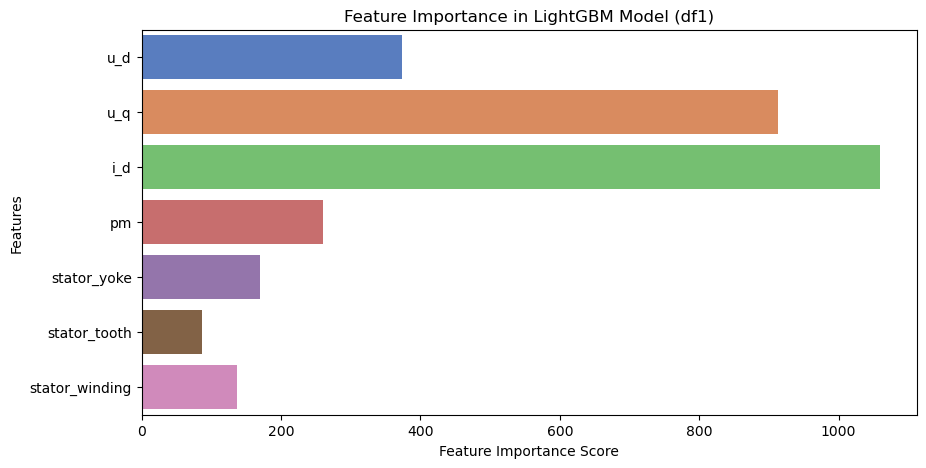

In [98]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# Step 1: Define features (X_lgbm_df1) and target (y_lgbm_df1)
X_lgbm_df1 = df1.drop(columns=['motor_speed'])  # Features
y_lgbm_df1 = df1['motor_speed']  # Target

# Step 2: Selecting top k features using ANOVA F-test
k_best_features_df1 = 7  # Exploring more relevant features
feature_selector_lgbm_df1 = SelectKBest(score_func=f_regression, k=k_best_features_df1)
X_selected_lgbm_df1 = feature_selector_lgbm_df1.fit_transform(X_lgbm_df1, y_lgbm_df1)

# Step 3: Selected feature names
selected_feature_names_df1 = X_lgbm_df1.columns[feature_selector_lgbm_df1.get_support()]
print("Selected Features:", selected_feature_names_df1)

# Step 4: Converting the selected features into DataFrame
X_selected_df_lgbm_df1 = pd.DataFrame(X_selected_lgbm_df1, columns=selected_feature_names_df1)

# Step 5: Splitting the data into training and testing sets
X_train_lgbm_df1, X_test_lgbm_df1, y_train_lgbm_df1, y_test_lgbm_df1 = train_test_split(
    X_selected_df_lgbm_df1, y_lgbm_df1, test_size=0.2, random_state=42
)

# Step 6: Standardizing the data (Only the selected features)
scaler_lgbm_df1 = StandardScaler()
X_train_scaled_lgbm_df1 = scaler_lgbm_df1.fit_transform(X_train_lgbm_df1)
X_test_scaled_lgbm_df1 = scaler_lgbm_df1.transform(X_test_lgbm_df1)

# Step 7: Initializing LightGBM model
lgbm_model_df1 = LGBMRegressor(learning_rate=0.1, n_estimators=100, max_depth=7, random_state=42)

# Step 8: Train the model
lgbm_model_df1.fit(X_train_scaled_lgbm_df1, y_train_lgbm_df1)

# Step 9: Predict on train and test sets
y_train_pred_lgbm_df1 = lgbm_model_df1.predict(X_train_scaled_lgbm_df1)
y_test_pred_lgbm_df1 = lgbm_model_df1.predict(X_test_scaled_lgbm_df1)

# Step 10: Calculate performance metrics
train_mse_lgbm_df1 = mean_squared_error(y_train_lgbm_df1, y_train_pred_lgbm_df1)
test_mse_lgbm_df1 = mean_squared_error(y_test_lgbm_df1, y_test_pred_lgbm_df1)
train_r2_lgbm_df1 = r2_score(y_train_lgbm_df1, y_train_pred_lgbm_df1)
test_r2_lgbm_df1 = r2_score(y_test_lgbm_df1, y_test_pred_lgbm_df1)
train_mae_lgbm_df1 = mean_absolute_error(y_train_lgbm_df1, y_train_pred_lgbm_df1)
test_mae_lgbm_df1 = mean_absolute_error(y_test_lgbm_df1, y_test_pred_lgbm_df1)

# Step 11: Calculate RMSE
train_rmse_lgbm_df1 = np.sqrt(train_mse_lgbm_df1)
test_rmse_lgbm_df1 = np.sqrt(test_mse_lgbm_df1)

# Step 12: Print results
print("\n*** Model Performance ***")
print("Train MSE is:", train_mse_lgbm_df1)
print("Test MSE:", test_mse_lgbm_df1, "\n")
print("Train RMSE is:", train_rmse_lgbm_df1)
print("Test RMSE is:", test_rmse_lgbm_df1, "\n")
print("Train R² Score:", train_r2_lgbm_df1)
print("Test R² Score:", test_r2_lgbm_df1, "\n")
print("Train MAE is", train_mae_lgbm_df1)
print("Test MAE is", test_mae_lgbm_df1)

print("___________________________________\n")

# Step 13: Perform Cross-Validation
cv_scores_lgbm_df1 = cross_val_score(lgbm_model_df1, X_train_scaled_lgbm_df1, y_train_lgbm_df1, cv=5, scoring="r2")

print("\n*** Cross-Validation Results ***")
print("Cross-validation scores:", cv_scores_lgbm_df1)
print("Mean CV R² Score:", np.mean(cv_scores_lgbm_df1))

# Step 14: Feature importance data visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=lgbm_model_df1.feature_importances_, y=selected_feature_names_df1, palette="muted")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in LightGBM Model (df1)")
plt.show()

## for df2

Selected Features: Index(['u_d', 'u_q', 'i_d', 'pm', 'stator_yoke', 'stator_tooth',
       'stator_winding'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1064652, number of used features: 7
[LightGBM] [Info] Start training from score 2202.216267

*** Model Performance ***
Train MSE is: 11212.782171716835
Test MSE: 11632.336029995906 

Train RMSE is: 105.89042530709203
Test RMSE is: 107.85330792328952 

Train R² Score: 0.9967587136573002
Test R² Score: 0.9966324844289193 

Train MAE is 48.38638918677841
Test MAE is 48.787892023571814
___________________________________

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

C:\Users\dell\AppData\Local\Temp\ipykernel_6448\599969201.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lgbm_model_df2.feature_importances_, y=selected_feature_names_df2, palette="muted")


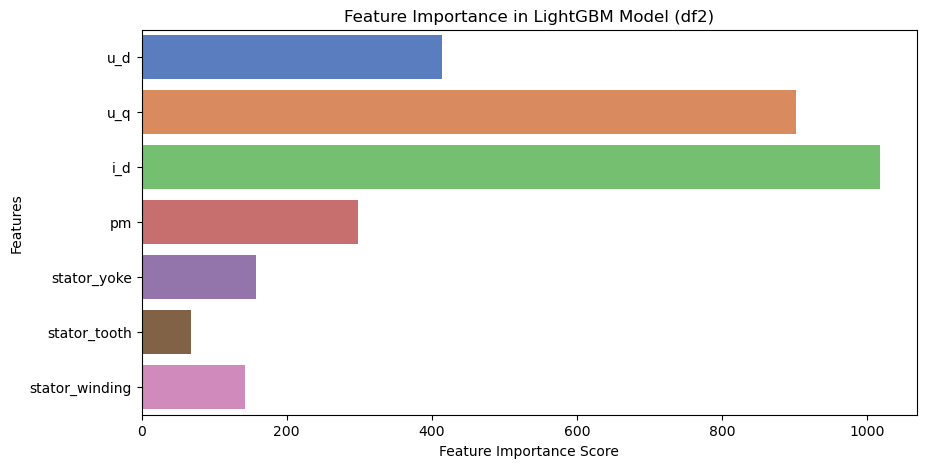

In [99]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score


# Step 1: Define features (X_lgbm_df2) and target (y_lgbm_df2)
X_lgbm_df2 = df2.drop(columns=['motor_speed'])  # Features
y_lgbm_df2 = df2['motor_speed']  # Target

# Step 2: Selecting top k features using ANOVA F-test
k_best_features_df2 = 7  # Increased k to 7 to explore more relevant features
feature_selector_lgbm_df2 = SelectKBest(score_func=f_regression, k=k_best_features_df2)
X_selected_lgbm_df2 = feature_selector_lgbm_df2.fit_transform(X_lgbm_df2, y_lgbm_df2)

# Step 3: Selected feature names
selected_feature_names_df2 = X_lgbm_df2.columns[feature_selector_lgbm_df2.get_support()]
print("Selected Features:", selected_feature_names_df2)

# Step 4: Converting the selected features into DataFrame
X_selected_df_lgbm_df2 = pd.DataFrame(X_selected_lgbm_df2, columns=selected_feature_names_df2)

# Step 5: Splitting the data into training and testing sets
X_train_lgbm_df2, X_test_lgbm_df2, y_train_lgbm_df2, y_test_lgbm_df2 = train_test_split(
    X_selected_df_lgbm_df2, y_lgbm_df2, test_size=0.2, random_state=42
)

# Step 6: Standardizing the data (Only the selected features)
scaler_lgbm_df2 = StandardScaler()
X_train_scaled_lgbm_df2 = scaler_lgbm_df2.fit_transform(X_train_lgbm_df2)
X_test_scaled_lgbm_df2 = scaler_lgbm_df2.transform(X_test_lgbm_df2)

# Step 7: Initializing LightGBM model
lgbm_model_df2 = LGBMRegressor(learning_rate=0.1, n_estimators=100, max_depth=7, random_state=42)

# Step 8: Train the model
lgbm_model_df2.fit(X_train_scaled_lgbm_df2, y_train_lgbm_df2)

# Step 9: Predict on train and test sets
y_train_pred_lgbm_df2 = lgbm_model_df2.predict(X_train_scaled_lgbm_df2)
y_test_pred_lgbm_df2 = lgbm_model_df2.predict(X_test_scaled_lgbm_df2)

# Step 10: Calculate performance metrics
train_mse_lgbm_df2 = mean_squared_error(y_train_lgbm_df2, y_train_pred_lgbm_df2)
test_mse_lgbm_df2 = mean_squared_error(y_test_lgbm_df2, y_test_pred_lgbm_df2)
train_r2_lgbm_df2 = r2_score(y_train_lgbm_df2, y_train_pred_lgbm_df2)
test_r2_lgbm_df2 = r2_score(y_test_lgbm_df2, y_test_pred_lgbm_df2)
train_mae_lgbm_df2 = mean_absolute_error(y_train_lgbm_df2, y_train_pred_lgbm_df2)
test_mae_lgbm_df2 = mean_absolute_error(y_test_lgbm_df2, y_test_pred_lgbm_df2)

# Step 11: Calculate RMSE
train_rmse_lgbm_df2 = np.sqrt(train_mse_lgbm_df2)
test_rmse_lgbm_df2 = np.sqrt(test_mse_lgbm_df2)

# Step 12: Print results
print("\n*** Model Performance ***")
print("Train MSE is:", train_mse_lgbm_df2)
print("Test MSE:", test_mse_lgbm_df2, "\n")
print("Train RMSE is:", train_rmse_lgbm_df2)
print("Test RMSE is:", test_rmse_lgbm_df2, "\n")
print("Train R² Score:", train_r2_lgbm_df2)
print("Test R² Score:", test_r2_lgbm_df2, "\n")
print("Train MAE is", train_mae_lgbm_df2)
print("Test MAE is", test_mae_lgbm_df2)

print("___________________________________\n")

# Step 13: Perform Cross-Validation
cv_scores_lgbm_df2 = cross_val_score(lgbm_model_df2, X_train_scaled_lgbm_df2, y_train_lgbm_df2, cv=5, scoring="r2")

print("\n*** Cross-Validation Results ***")
print("Cross-validation scores:", cv_scores_lgbm_df2)
print("Mean CV R² Score:", np.mean(cv_scores_lgbm_df2))

# Step 14: Feature importance data visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=lgbm_model_df2.feature_importances_, y=selected_feature_names_df2, palette="muted")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in LightGBM Model (df2)")
plt.show()

### Performance For Df1 DataFrame

In [123]:
metrics_df1 = {
    'Model': ['Random Forest', 'LightGBM','Linear Regression', 'XGBoost', 'Neural Networks','KNN'],
    'R²': [test_r2_df1, test_r2_lgbm_df1, r2_LR_df1, test_r2_XGB_df1, r2_nn_df1,test_r2_KNN_df1],  # Replace with actual R² values
    'MSE': [mse_df1, test_mse_lgbm_df1,  mse_LR_df1, mse_XGB_df1, mse_nn_df1,mse_KNN_df1],  # Replace with actual MSE values
    'RMSE': [rmse_df1, test_rmse_lgbm_df1, rmse_LR_df1, rmse_XGB_df1, rmse_nn_df1,rmse_KNN_df1]  # Replace with actual RMSE values
}

# Create a DataFrame from the metrics dictionary
Performance_for_Df1 = pd.DataFrame(metrics_df1)



Performance_for_Df1_sorted = Performance_for_Df1.sort_values(by='R²', ascending=False)
Performance_for_Df1_sorted


,Model,R²,MSE,RMSE
0,Random Forest,0.999908,326.573087,18.071333
3,XGBoost,0.999708,1038.410522,32.224378
5,KNN,0.999369,2247.274265,47.405424
1,LightGBM,0.996939,10893.885756,104.373779
4,Neural Networks,0.976197,84712.928842,291.054855
2,Linear Regression,0.964263,127184.631629,356.629544


### Performance For Df2 DataFrame

In [124]:
metrics_df2 = {
    'Model': ['Random Forest', 'LightGBM', 'Decision Tree', 'Linear Regression', 'XGBoost', 'Neural Networks','KNN'],
    'R²': [test_r2_df2, test_r2_lgbm_df2, test_r2_final_df2, r2_LR_df2, test_r2_XGB_df2, r2_nn_df2,test_r2_KNN_df2],  
    'MSE': [mse_df2, test_mse_lgbm_df2, mse_final_df2, mse_LR_df2, mse_XGB_df2, mse_nn_df2,mse_KNN_df2],  
    'RMSE': [rmse_df2, test_rmse_lgbm_df2, rmse_final_df2, rmse_LR_df2, rmse_XGB_df2, rmse_nn_df2,rmse_KNN_df2]  
}

# Create a DataFrame from the metrics dictionary
Performance_for_Df2 = pd.DataFrame(metrics_df2)

Performance_for_Df2_sorted = Performance_for_Df2.sort_values(by='R²', ascending=False)
Performance_for_Df2_sorted

,Model,R²,MSE,RMSE
0,Random Forest,0.999885,397.296127,19.932289
2,Decision Tree,0.999755,845.486467,29.077250
4,XGBoost,0.999644,1228.957319,35.056488
6,KNN,0.999342,2272.459552,47.670322
1,LightGBM,0.996632,11632.336030,107.853308
5,Neural Networks,0.982256,61291.999896,247.572211
3,Linear Regression,0.940295,206236.626602,454.132829


#### Checking Min Max values for all features  **(Range for Deployment)**

In [78]:
# Calculate minimum and maximum values for each column
min_max_values = df1.agg(['min', 'max'])

# Display the results
print("Minimum and Maximum values for each feature:")
min_max_values

Minimum and Maximum values for each feature:


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
min,18.636507,12.914791,-131.530411,-17.991308,-275.549144,-139.224811,-269.230377,-151.611850,20.856956,18.076689,18.133976,18.585815
max,30.714205,95.898277,121.640929,133.036994,6000.015137,230.548001,0.051897,255.616914,113.606628,101.147964,111.946423,141.362885


In [79]:
df1.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,19.850691,18.805172,-0.350055,-0.450682,0.002866,0.187101,0.004419,0.000328,24.554214,18.316547,18.293219,19.086670
1,19.850672,18.818571,-0.305803,-0.325737,0.000257,0.245417,0.000606,-0.000785,24.538078,18.314955,18.294807,19.092390
2,19.850657,18.828770,-0.372503,-0.440864,0.002355,0.176615,0.001290,0.000386,24.544693,18.326307,18.294094,19.089380
3,19.850647,18.835567,-0.316199,-0.327026,0.006105,0.238303,0.000026,0.002046,24.554018,18.330833,18.292542,19.083031
4,19.850639,18.857033,-0.332272,-0.471150,0.003133,0.208197,-0.064317,0.037184,24.565397,18.326662,18.291428,19.082525


## Save the model and scaler


In [128]:
import joblib

# Save the trained Random Forest model
joblib.dump(model_df1, 'random_forest_model_df1.pkl')

# Save the StandardScaler
joblib.dump(scaler_df1, 'scaler_df1.pkl')

['scaler_df1.pkl']

In [130]:
# Also save the target scaler

target_scaler_df1 = StandardScaler()
target_scaler_df1.fit(y_train_df1.values.reshape(-1, 1))
joblib.dump(target_scaler_df1, 'target_scaler_df1.pkl')


['target_scaler_df1.pkl']